In [1]:
import numpy as np
from PIL import Image, ImageDraw
import time
from random import sample
import numpy.random as random

# GridWorld

In [2]:
class GridWorld:
    def __init__(self, board_dims, start_state, terminal_state, reward_matrix):
        self.board_dims = board_dims
        self.height, self.width = board_dims
        self.start_state = start_state
        self.agent_pos = start_state
        self.terminal_state = terminal_state
        self.reward_matrix = reward_matrix
        self.moves = [(-1,0),(0,-1),(1,0),(0,1)] #up,left,down,right
        
    def get_moves(self, point):
        """
        point - the point our agent is in
        This function obtains the points of possible moves you can potentially make from the point provided
        """
        return [tuple(np.array(point)+np.array(x)) for x in self.moves]

    def point_to_index(self, point):
        """
        point - the point we want to convert to index (for list of lists e.g.)
        This function obtains the index when you iterate across each column over each row of our game board
        """
        return point[0]*self.width + point[1]

    def index_to_point(self, index):
        """
        index - the index we want to convert to game square point
        This function obtains the index when you iterate across each column over each row of our game board
        """
        #(divisions, remainder)
        return (index // self.width, index % self.width)

    def get_reward(self,point):
        """
        point - a point in our grid
        This function returns the reward for our agent going to the state represented by point
        """
        return self.reward_matrix[point]
    
    def illegal_move(self,point):
        """
        point - a point that may or may not be in our grid
        This function returns true if the move we make takes us off the board and false if the move is legal
        """
        return True if ((point[0] < 0 or point[0] == self.height) or (point[1] < 0 or point[1] == self.width)) else False
        
    def print_board(self):
        print(self.reward_matrix)

# Individual Game Implementations

Here we define each game and have it inherit attributes from GridWorld object

## Targeting Game

In [3]:
class Targeting_Game(GridWorld):
    def __init__(self, board_dims, start_state, terminal_state, reward_matrix):
        GridWorld.__init__(self,board_dims, start_state, terminal_state, reward_matrix)
        
    def draw(self):
        """
        agent_pos - tuple point representing agent's current position on game board 
        remaining_prizes - list of tuples representing remaining prizes and their positions on game board
        This function draws our environment
        """

        image = Image.new("RGB", (501, 501), "black")
        draw = ImageDraw.Draw(image)

        w = 500/(self.width)
        h = 500/(self.height)
        color = "white"

        #Draw Grid and Start/Stop Squares
        for i in range(self.height):
            for j in range(self.width):
                if(i == self.start_state[0] and j == self.start_state[1]):
                    color = "blue"
                elif(i == self.terminal_state[0] and j == self.terminal_state[1]):
                    color = "red"
                draw.rectangle(((0+j*w, 0+i*h),(w+j*w, h+i*h)), outline = "black", fill = color)
                color ="white"

        #Draw Agent
        draw.ellipse((self.agent_pos[1]*w + w/4, self.agent_pos[0]*h + h/4, 3*w/4 + self.agent_pos[1]*w, 3*h/4 + self.agent_pos[0]*h), fill="black")

        display(image)

    def update_state(self,new_pos):
      """
      new_pos - a point in the game grid that the agent has moved to
      This function updates the agent position for the GameGrid class variable.
      """
      self.agent_pos = new_pos

    def refresh_game(self):
        self.agent_pos = self.start_state

## Collection Game

In [14]:
class Collection_Game(GridWorld):
    def __init__(self, board_dims, start_state, prize_states, reward_matrix, prize_value=0):
        GridWorld.__init__(self,board_dims, start_state, None, reward_matrix)
        self.prize_states = prize_states
        self.remaining_prize_states = list(prize_states)
        self.prize_value = prize_value
        for prize_state in prize_states:
            self.reward_matrix[prize_state] = prize_value
    
    def draw(self):
        """
        agent_pos - tuple point representing agent's current position on game board 
        remaining_prizes - list of tuples representing remaining prizes and their positions on game board
        This function draws our environment
        """

        image = Image.new("RGB", (501, 501), "black")
        draw = ImageDraw.Draw(image)

        w = 500/(self.width)
        h = 500/(self.height)
        color = "white"

        #Draw Grid and Start/Stop Squares
        for i in range(self.height):
            for j in range(self.width):
                if(i == self.start_state[0] and j == self.start_state[1]):
                    color = "blue"
                draw.rectangle(((0+j*w, 0+i*h),(w+j*w, h+i*h)), outline = "black", fill = color)
                color ="white"

        #Draw Agent
        draw.ellipse((self.agent_pos[1]*w + w/4, self.agent_pos[0]*h + h/4, 3*w/4 + self.agent_pos[1]*w, 3*h/4 + self.agent_pos[0]*h), fill="black")

        #Draw Prizes
        if len(self.remaining_prize_states) > 1:
            for x in self.remaining_prize_states:
                draw.rectangle(((x[1]*w + w/4, x[0]*h + h/4), (3*w/4+x[1]*w, 3*h/4+x[0]*h)), outline = "black", fill = "yellow")
        elif len(self.remaining_prize_states) == 1:
            remaining_prize = self.remaining_prize_states[0]
            draw.rectangle(((remaining_prize[1]*w + w/4, remaining_prize[0]*h + h/4), (3*w/4+remaining_prize[1]*w, 3*h/4+remaining_prize[0]*h)), outline = "black", fill = "yellow")
      
        display(image)

    def update_state(self,new_pos):
        """
        new_pos - a point in the game grid that the agent has moved to
        This function updates the agent position for the GameGrid class variable.
        """
        self.agent_pos = new_pos
        if self.agent_pos in self.remaining_prize_states:
            self.remove_prize(self.agent_pos)

    def remove_prize(self, prize_point):
        """
        prize_point - a point in the game grid that contained a prize
        This function removes the prize at the prize_point supplied from the remaining prizes. This function also
            updates the reward matrix accordingly.
        """
        #remove prize from remaining prizes
        self.remaining_prize_states.remove(prize_point)
        #adjust reward matrix to account for no prize at this prize_point for the rest of the episode
        #self.reward_matrix[prize_point] = self.reward_matrix[self.start_state]
        #if there remains one prize, set that to be the terminal state for the episode
        if len(self.remaining_prize_states) == 1:
            self.terminal_state = self.remaining_prize_states[0]
        
    def refresh_game(self):
        """
        This function refreshes the game's agent position, the remaining prizes, the reward matrix, and terminal 
            state. This is used between each episode
        """
        self.agent_pos = self.start_state
        self.remaining_prize_states = list(self.prize_states)
        self.terminal_state = None
        
        for prize_state in self.prize_states:
            self.reward_matrix[prize_state] = self.prize_value

# Agents

Here we define different agents and allow them to play our games that we define above in the previous section

## TD Off-Policy Agent: Q-Learning

In [15]:
class QLearningTable:
    """
    This class implements the qtable object with qlearning update rules
    """
    def __init__(self, Game, alpha, discount):
        self.Game = Game
        self.matrix = np.zeros([Game.height*Game.width, len(Game.moves)])
        self.alpha = alpha
        self.discount = discount
        self.target_policy = np.ones_like(self.matrix) / len(Game.moves)

    def get_target_policy(self):
        """
        This function gets the deterministic (greedy) policy derived from the qtable
        """
        current_state = self.Game.start_state
        move_idxs = np.arange(len(self.Game.moves))
        while current_state != self.Game.terminal_state:
            next_action_idx = np.argmax(self.matrix[self.Game.point_to_index(current_state), :])
            
            self.target_policy[self.Game.point_to_index(current_state), next_action_idx] = 1
            not_next_action_idxs = move_idxs[np.arange(len(move_idxs))!=next_action_idx]
        
            self.target_policy[self.Game.point_to_index(current_state),not_next_action_idxs] = 0
            
            next_action = self.Game.moves[next_action_idx]
            current_state = tuple(np.array(current_state) + np.array(next_action))
        
    def get_return(self, state, action):
        """
        state - some integer index corresponding to a tuple point in the grid game
        action - some integer index corresponding to a possible action taken in the grid game
        This function returns the expected return from the qtable for a specific action made in a specific state
        """
        return self.matrix[state, action]

    def max_lookahead(self, state):
        """
        state - this is s', a point in the grid where are agent is going to be when taking action a in state s
        This function finds the best action which maximizes the next move made from s' (state)
        """
        aprime = np.argmax(self.matrix[state, :])
        return self.get_return(state,aprime)

    def update_qtable(self, state, action, reward, new_state):
        """
        state - a point on the grid where your agent is performing an action from (converted to index in qtable)
        action - this is an integer corresponding to a tuple that makes the agent move up, left, down, or right and represents 
          the selected move made by the agent in the state provided above
        (state, action) pair provided above can be plugged directly into qtable
        reward - this is an integer corresponding to the reward for the above (state, action) tuple
        """
        # action equals 0, 1, 2, 3
        current_reward = self.matrix[state,action]
        self.matrix[state, action] = current_reward + self.alpha * (reward + self.discount * self.max_lookahead(new_state) - current_reward)
        

In [7]:
class QLearningAgent:
    """
    This class implements a temporal difference off-policy (qlearning) agent that can play grid games
    """
    def __init__(self, Game, model):
        self.Game = Game
        self.model = model
        self.behavior_policy = np.ones_like(self.model.matrix) / len(self.Game.moves)
        self.target_policy = None
        
    def get_target_policy(self):
        """
        This function obtains the deterministic (greedy) policy from the qtable
        """
        self.model.get_target_policy()
        self.target_policy = self.model.target_policy
    
    def update_model(self, state, action, reward, new_state):
        """
        state - a tuple point corresponding to a square in a grid game
        action - a tuple move corresponding to an action made in a grid game
        reward - the reward derived from the game's reward matrix for specific action taken in specific state
        new_state - a tuple point corresponding to the square in the grid game that your agent moved to 
            from taking the action described above in the state described above
        This function updates the qtable by calling update_qtable and passing the necessary information about the game environment
        """
        new_state = self.Game.point_to_index(new_state)
        state = self.Game.point_to_index(state)
        action = self.Game.moves.index(action)
        self.model.update_qtable(state, action, reward, new_state)
    
    def get_action(self, state):
        """
        state - a tuple point that corresponds to a square in a grid game
        This function obtains an action from the games possible moves based on the agent's behavior policy
        """
        probs = self.behavior_policy[self.Game.point_to_index(state),:]
        print("probs", probs)
        r = random.random()
        for move_idx, prob in enumerate(probs):
            if r > prob:
                r -= prob
            else:
                return self.Game.moves[move_idx]

        return self.moves[random.randint(0,len(self.moves))]
    
    def play_game(self, episodes, output=False):
        """
        episodes - an integer that corresponds to the number of times your agent plays the game
        This function has your agent play the game and update its model of the game
        """
        player_scores = []
        #number of times player plays the game is episodes.

        for i in range(episodes):
            #in each episode, the player needs to complete the task in T steps (t = 0,1,...,t-2,t-1,T)

            t = 0
            episode_reward = 0
            self.Game.draw()

            #while agent is not in a terminal state
            while self.Game.agent_pos != self.Game.terminal_state:
                #Take action A, get reward R, step into s'
                #Find a that is max(s',a)

                if output:
                    print("Player's position",self.Game.agent_pos)

                t += 1

                #get possible moves going up, left, down, and right
                new_action = self.get_action(self.Game.agent_pos)
                new_state = tuple(np.array(self.Game.agent_pos) + np.array(new_action))

                #if move is illegal (going off the board), set reward to very bad
                if self.Game.illegal_move(new_state):
                    reward = -10000
                    self.update_model(self.Game.agent_pos, new_action, reward, self.Game.agent_pos)
                else:
                #else the selected move is legal and we should get reward r for agent going to state s'
                    reward = self.Game.get_reward(new_state)
                    self.update_model(self.Game.agent_pos, new_action, reward, new_state)
                    self.Game.update_state(new_state)

                episode_reward += reward

                
#                 print("Player's possible moves: ",self.Game.get_moves(self.Game.agent_pos))
#                 print("Player's chosen move",new_state)
#                 print("Player's new position",self.Game.agent_pos)
#                 print("Player's reward for this move",reward)
#                 print("Number of moves made to perform task: ",t)

                if self.Game.terminal_state is not None and self.Game.agent_pos in self.Game.terminal_state:
                    print("Player found the target square: ",self.Game.terminal_state)

#                 self.Game.draw()
                

            player_scores.append(episode_reward)

            print("Player finished task in :",t, " moves")
            self.Game.refresh_game()

        print("Player scores for every episode: ",player_scores)
        self.Game.refresh_game()

# Game-Agent Testing

In [8]:
reward_matrix = np.ones((3,3))*-1
reward_matrix[(2,2)] = 0
print(reward_matrix)
target_game = Targeting_Game( (3,3), (0,0), (2,2), reward_matrix)


qtable = QTable(target_game, 0.1, 0.25)
agent = Agent(target_game, qtable)

#play_game(target_game, 1, output=True)

[[-1. -1. -1.]
 [-1. -1. -1.]
 [-1. -1.  0.]]


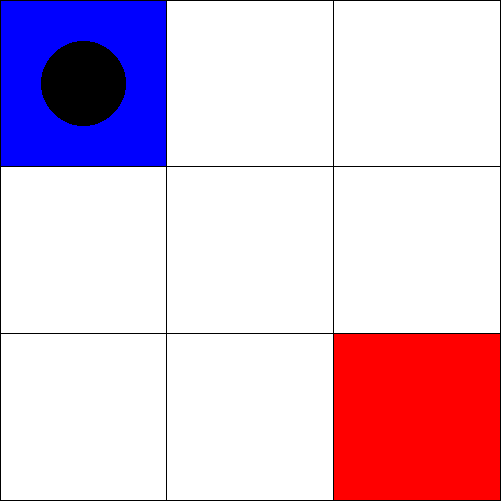

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 7  moves


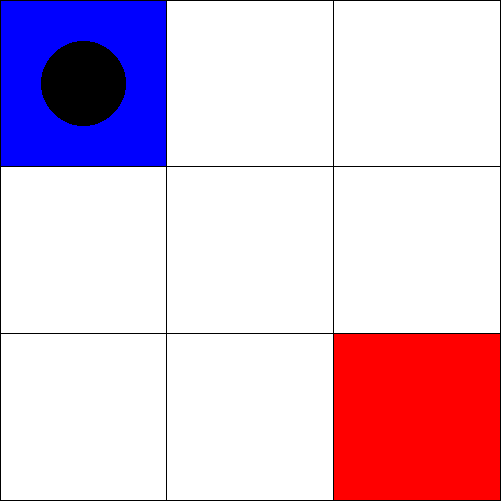

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 5  moves


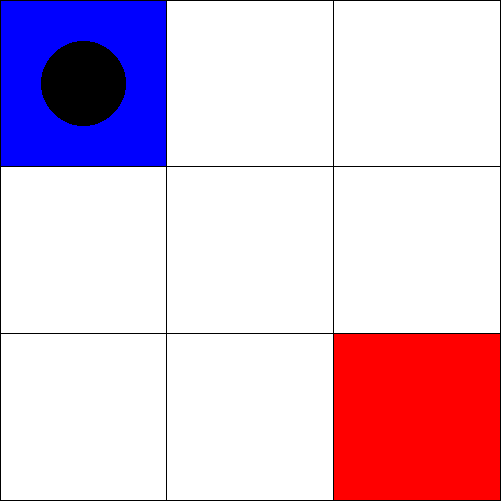

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 11  moves


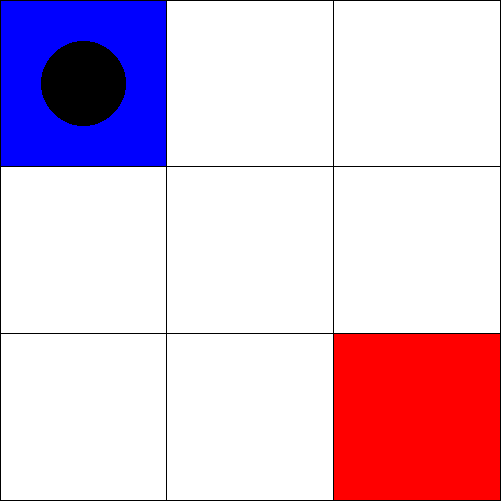

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 20  moves


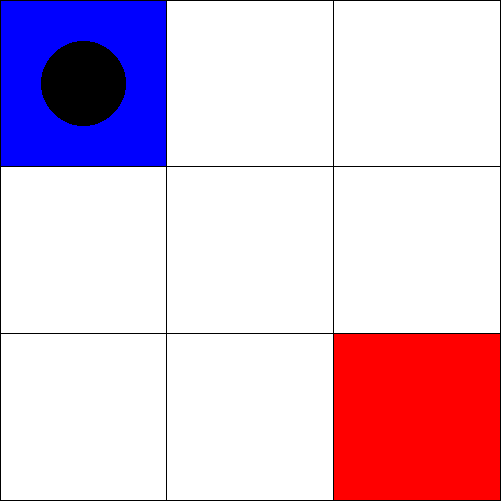

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.2

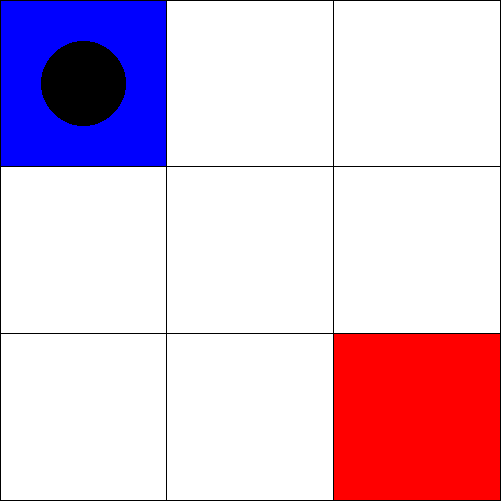

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.2

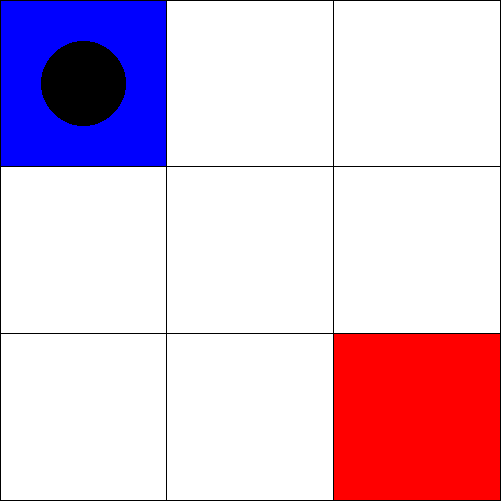

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 13  moves


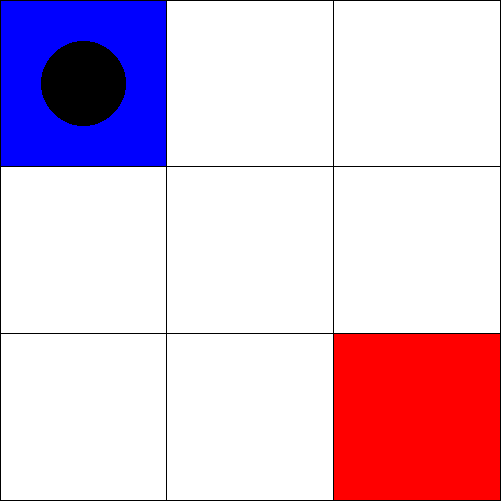

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 9  moves


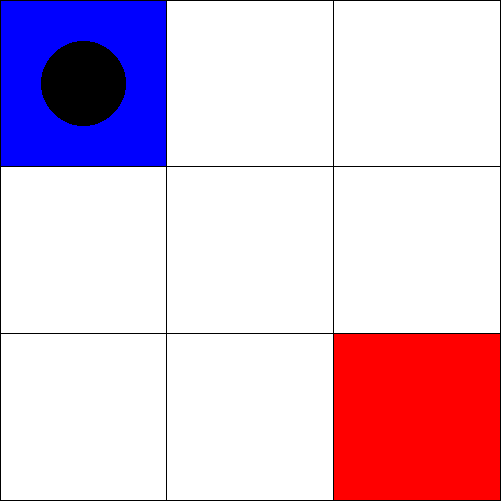

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 17  moves


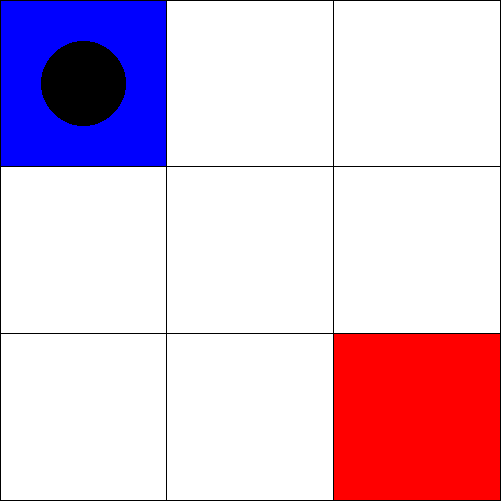

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 23  moves


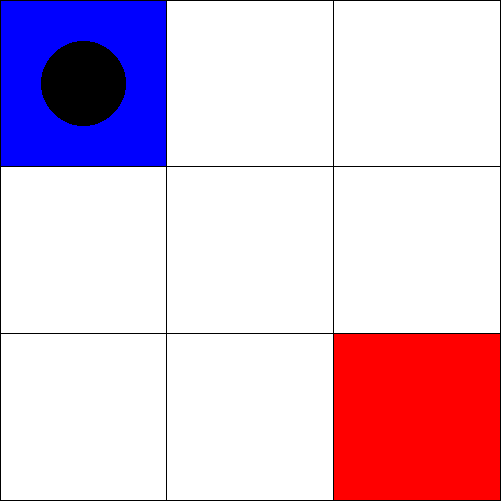

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.2

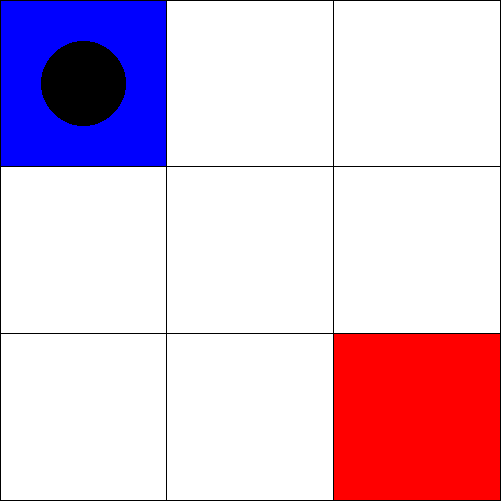

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 7  moves


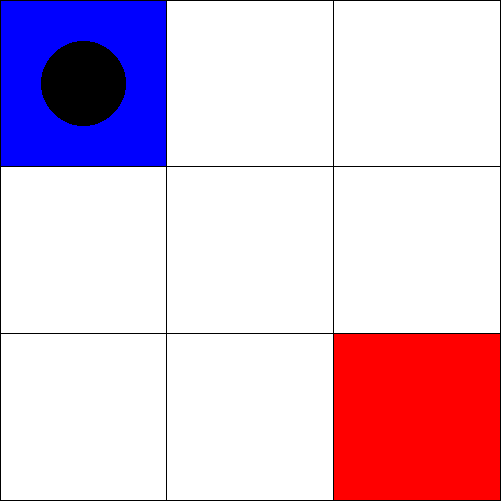

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 22  moves


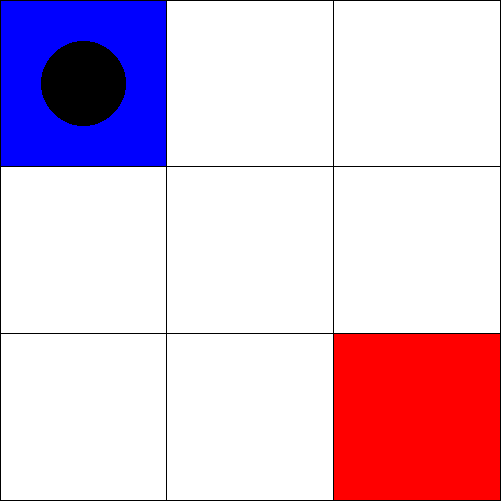

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 9  moves


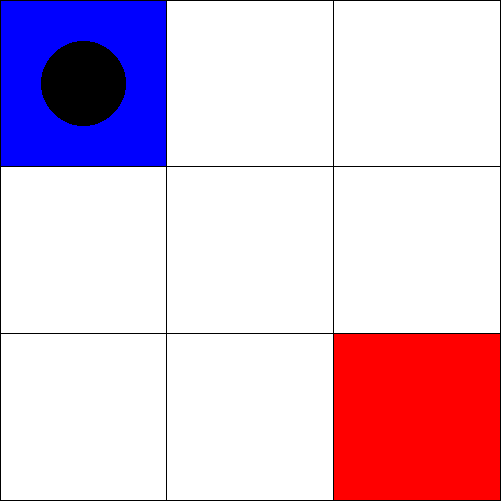

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 27  moves


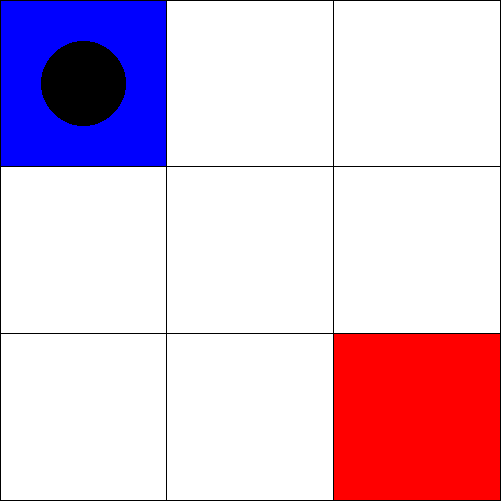

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 28  moves


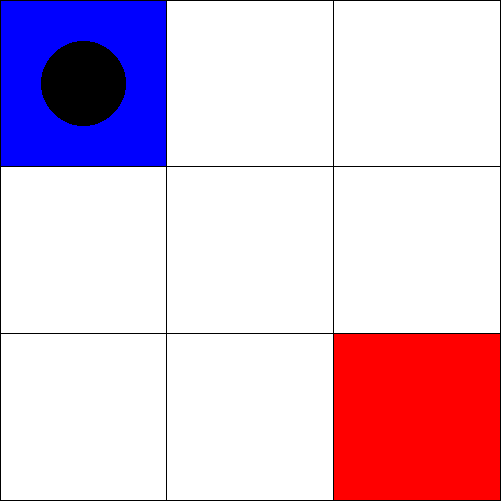

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 26  moves


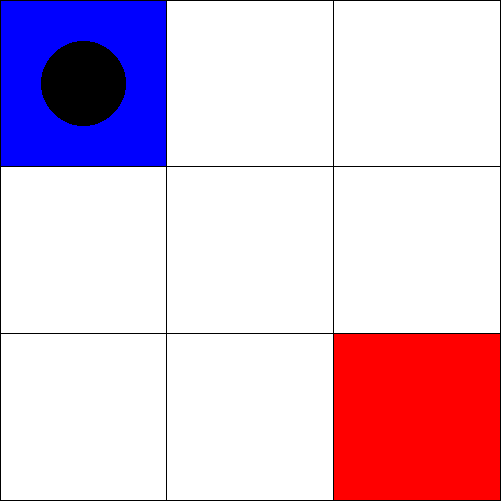

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.2

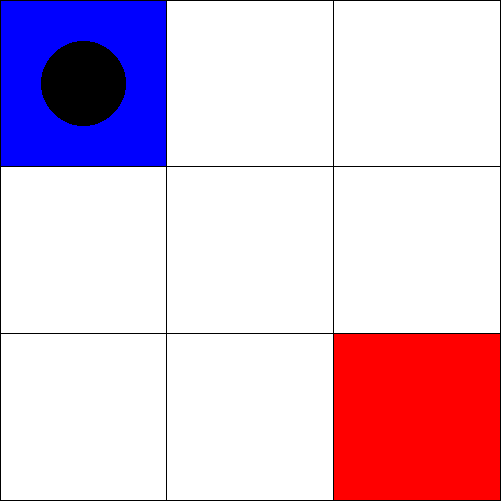

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.2

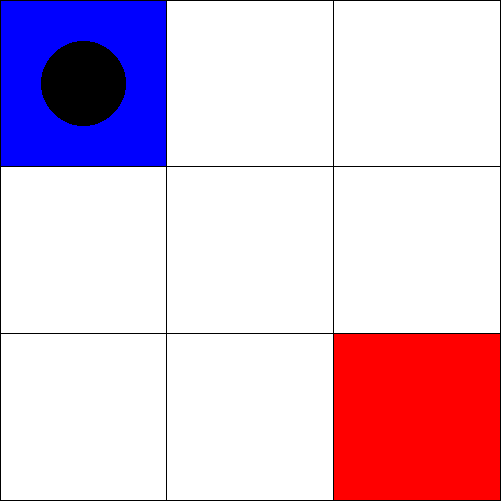

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.2

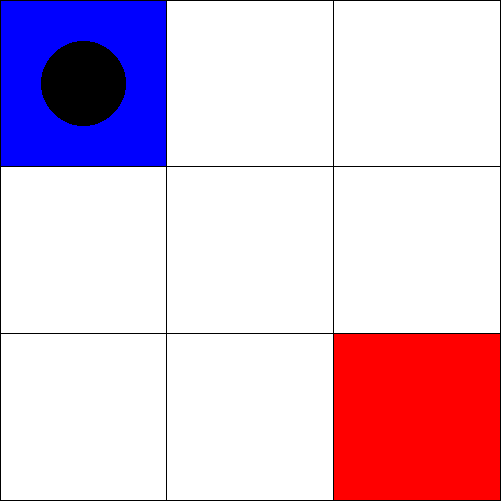

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.2

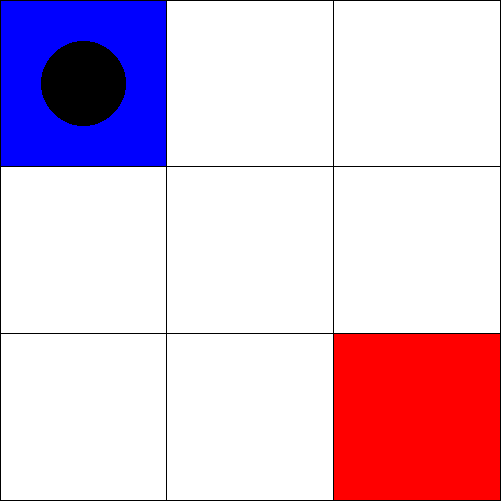

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 10  moves


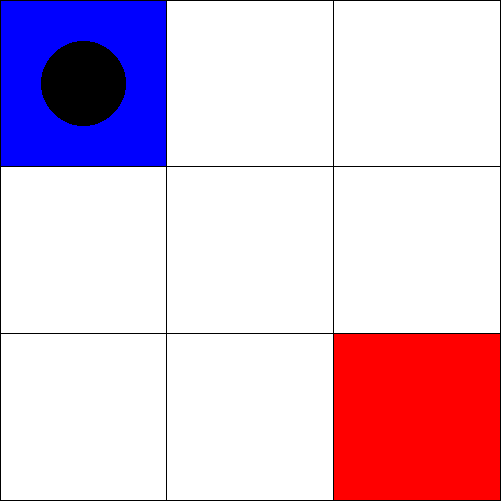

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 13  moves


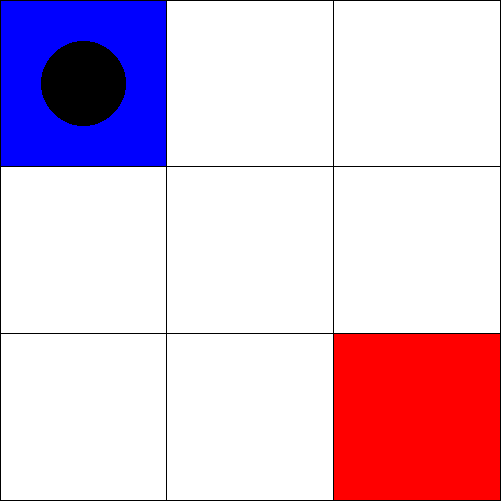

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 21  moves


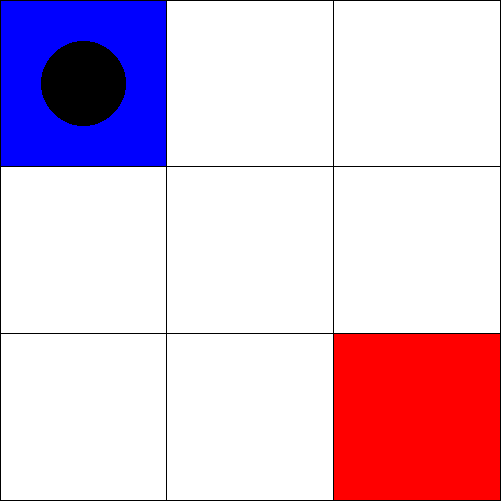

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.2

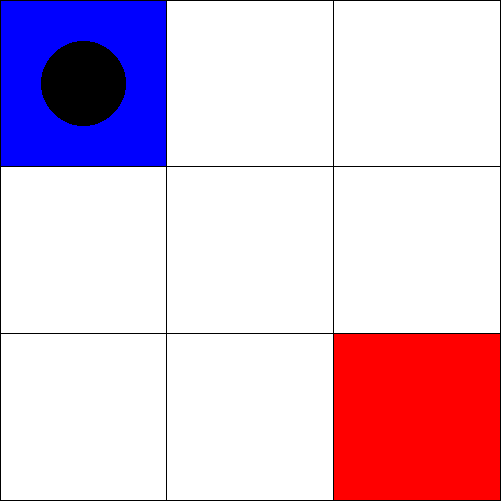

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 30  moves


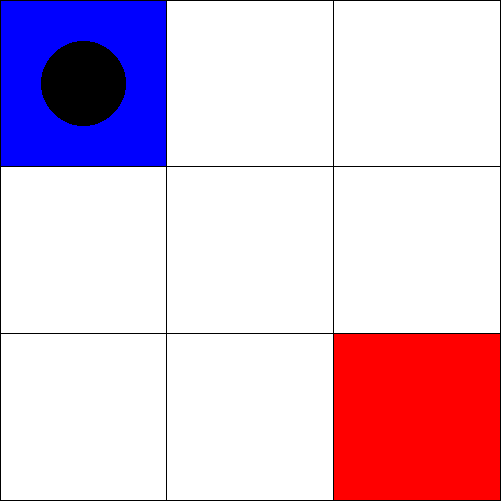

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 12  moves


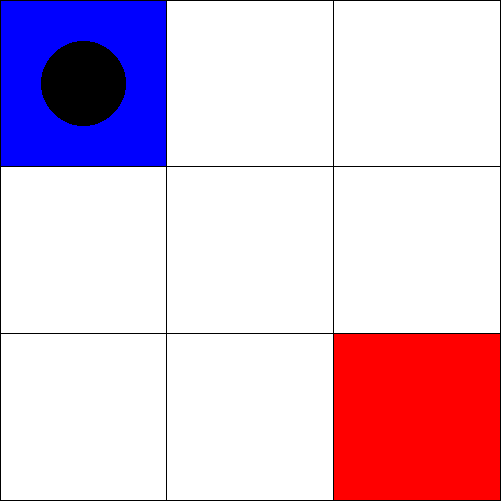

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 19  moves


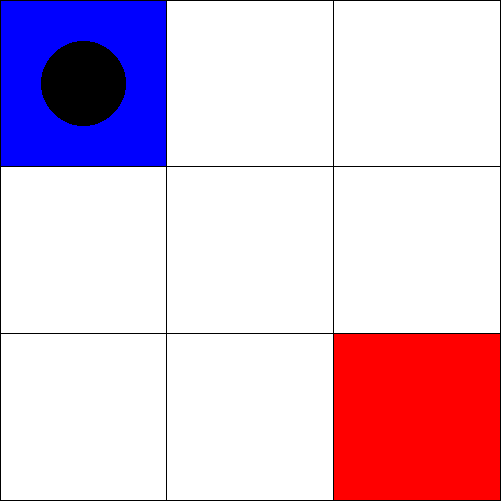

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 10  moves


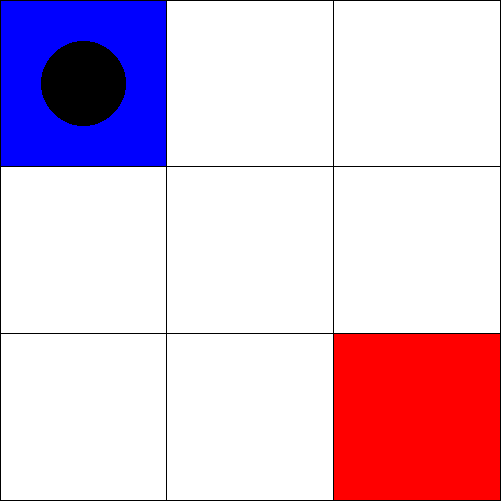

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 11  moves


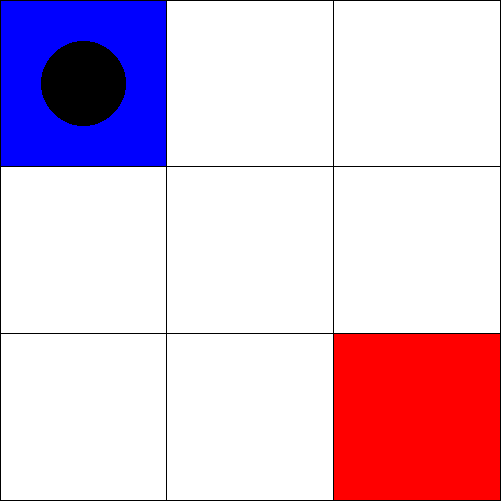

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.2

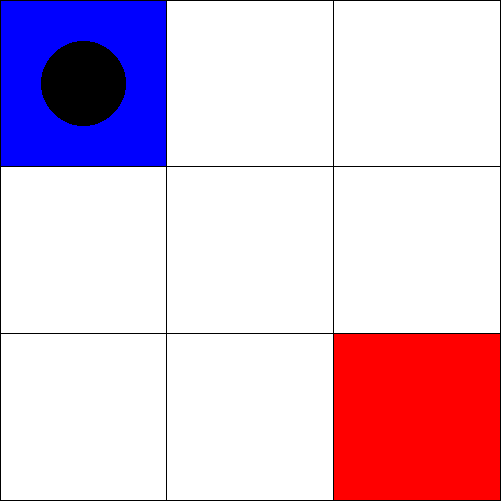

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 11  moves


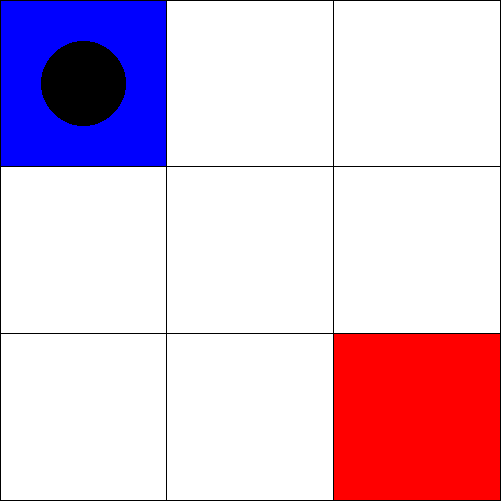

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 13  moves


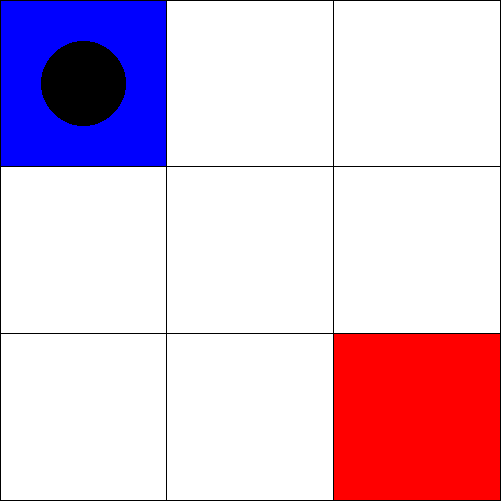

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 25  moves


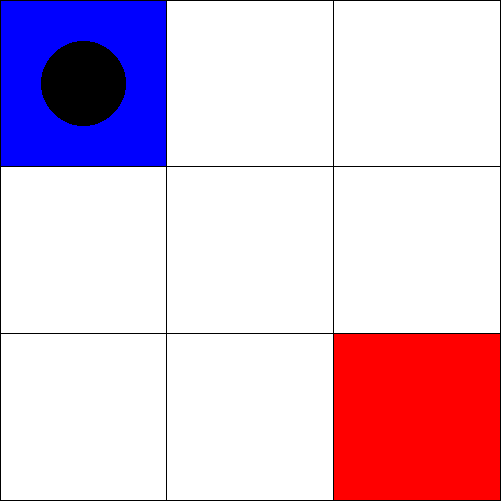

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 14  moves


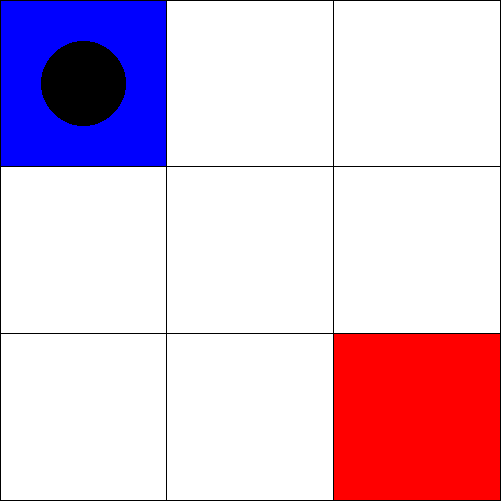

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 27  moves


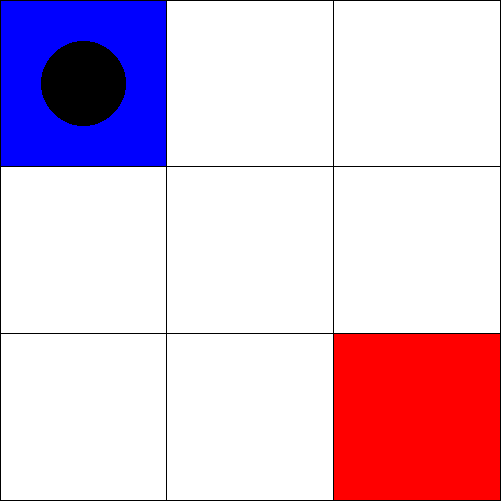

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.2

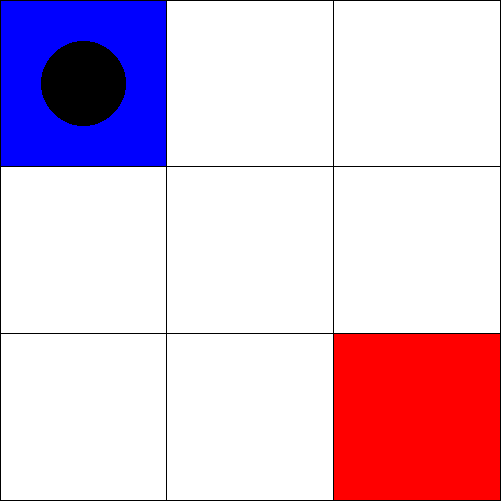

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 15  moves


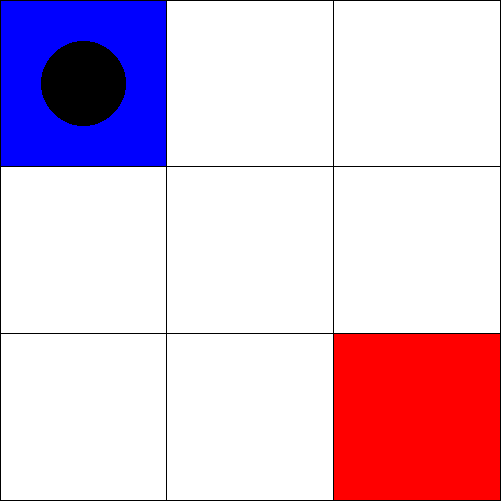

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 8  moves


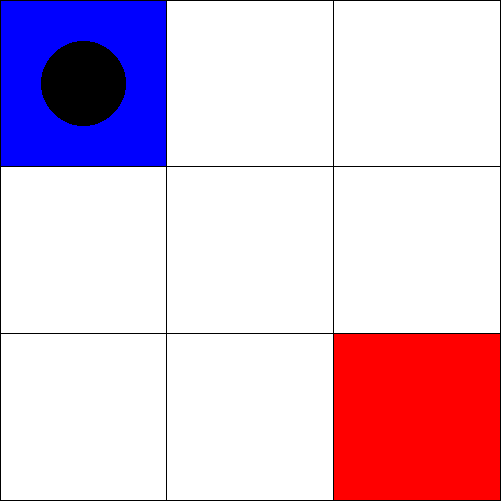

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 18  moves


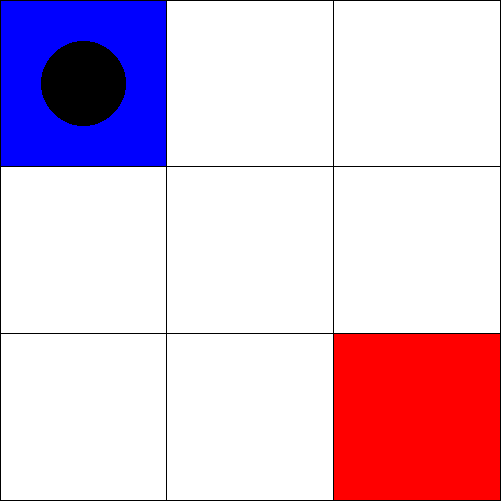

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 24  moves


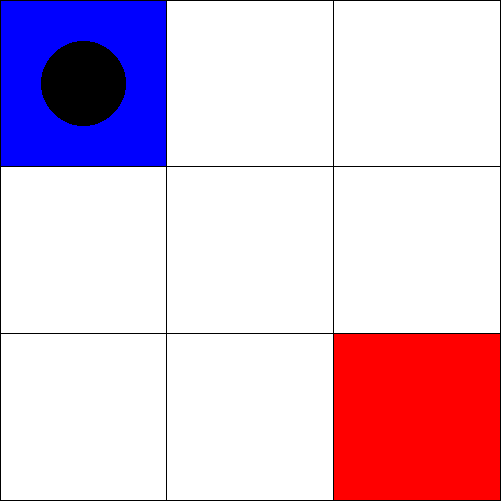

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 24  moves


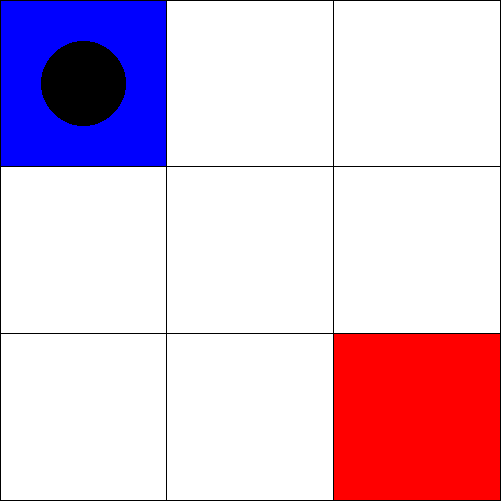

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 30  moves


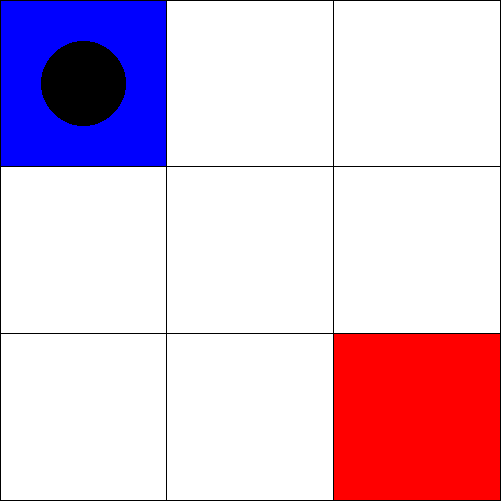

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 31  moves


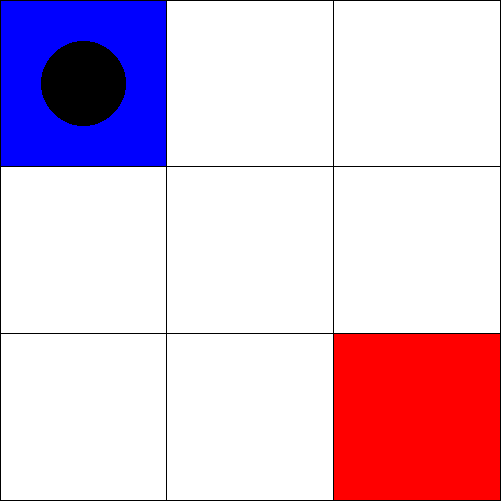

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 22  moves


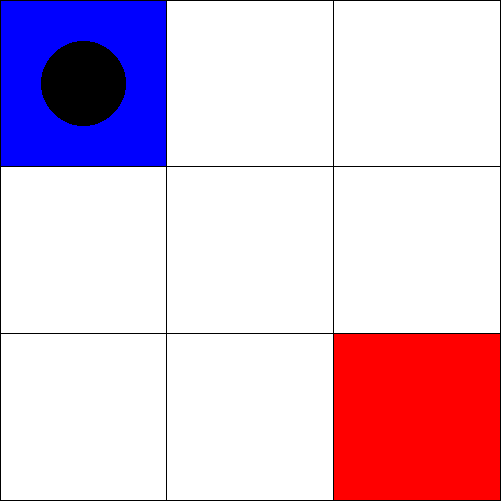

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 6  moves


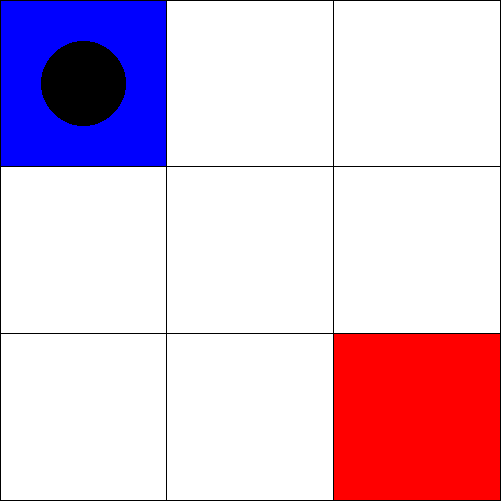

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.2

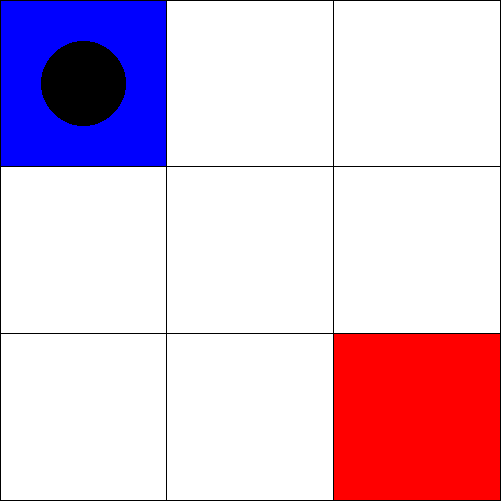

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 11  moves


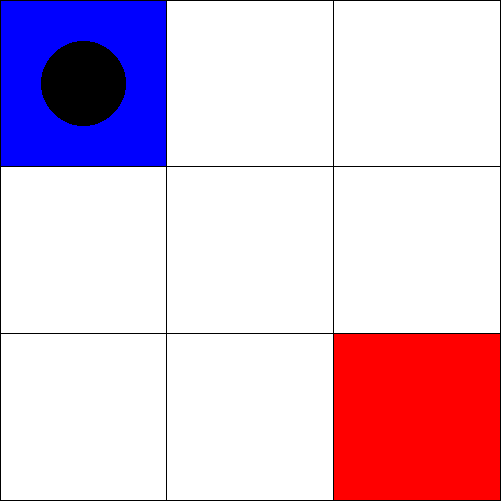

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 8  moves


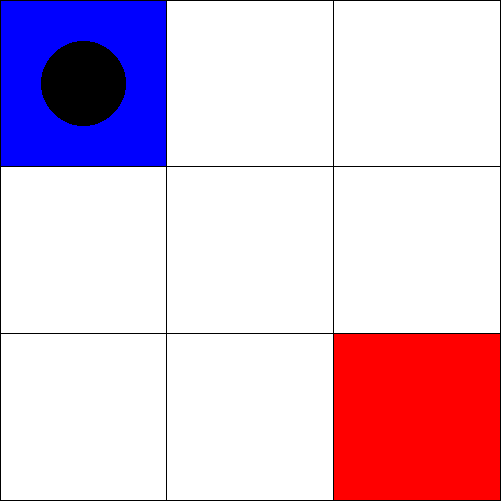

probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
probs [0.25 0.25 0.25 0.25]
Player finished task in : 18  moves
Player scores for every episode:  [-10005.0, -10003.0, -50005.0, -60013.0, -190027.0, -140021.0, -70005.0, -50003.0, -70009.0, -90013.0, -130029.0, -10005.0, -40017.0, -50003.0, -130013.0, -100017.0, -100015.0, -170051.0, -200023.0, -130025.0, -160019.0, -40005.0, -90003.0, -70013.0, -100031.0, -60023.0, -60005.0, -70011.0, -40005.0, -10009.0, -110035.0, -50005.0, -50007.0, -30021.0, -20011.0, -50021.0, -220027.0, -50009.0, -20005.0, -40013.0, -60017.0, -1

In [9]:
agent.play_game(50)

In [10]:
np.set_printoptions(suppress=True)
print(agent.model.matrix)
agent.get_target_policy()
print(agent.target_policy)

[[-9958.56330304 -9982.34139682    -1.28406872    -1.28597023]
 [-9942.99298725    -1.26903493    -1.19460013    -1.21499588]
 [-8905.99524735    -1.10218684    -0.9835768  -9282.25101752]
 [   -1.28334148 -9903.29533586    -1.21844936    -1.19055896]
 [   -1.23119459    -1.24599696    -0.9774716     -0.90152291]
 [   -0.94099847    -1.02034628     0.         -9202.33556923]
 [   -1.23955601 -9835.98531585 -9958.48885459    -0.9774716 ]
 [   -1.04518689    -1.14449259 -7712.3207545      0.        ]
 [    0.             0.             0.             0.        ]]
[[0.   0.   1.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   1.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]


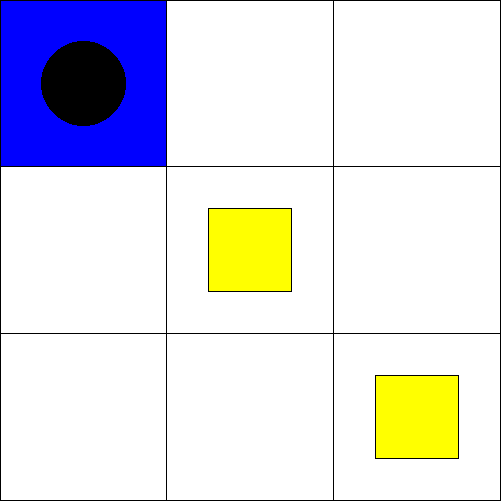

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (0, -1)
Player's new position (0, 0)
Player's reward for this move -10000
Number of moves made to perform task:  1


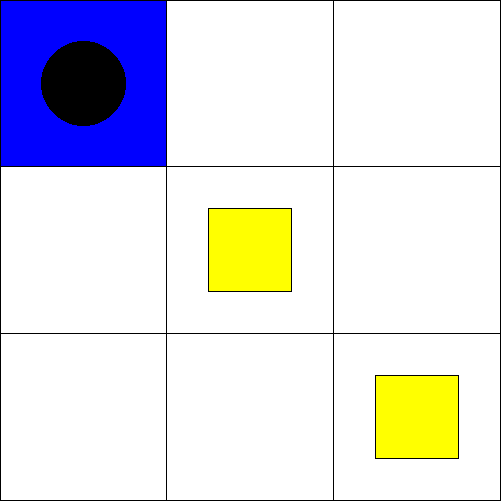

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (0, -1)
Player's new position (0, 0)
Player's reward for this move -10000
Number of moves made to perform task:  2


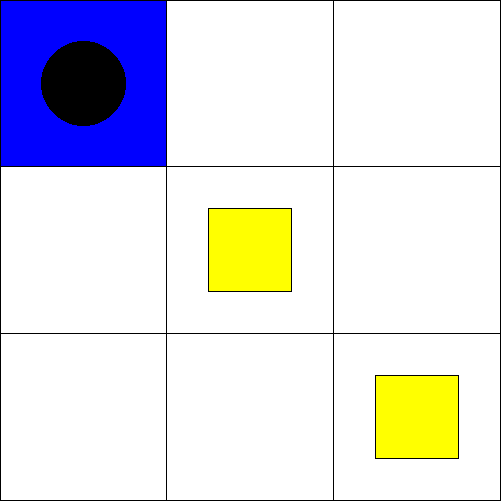

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (0, 1)
Player's new position (0, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  3


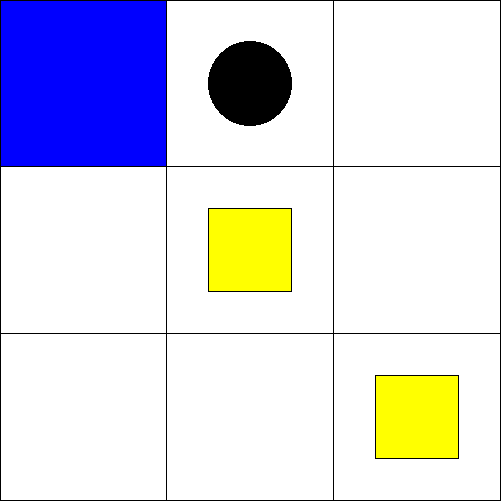

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (-1, 1)
Player's new position (0, 1)
Player's reward for this move -10000
Number of moves made to perform task:  4


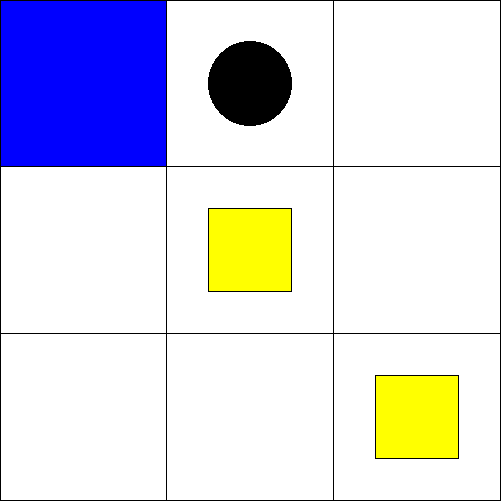

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (0, 0)
Player's new position (0, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  5


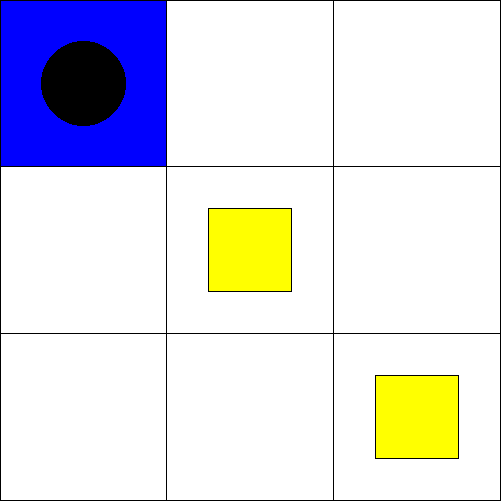

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (1, 0)
Player's new position (1, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  6


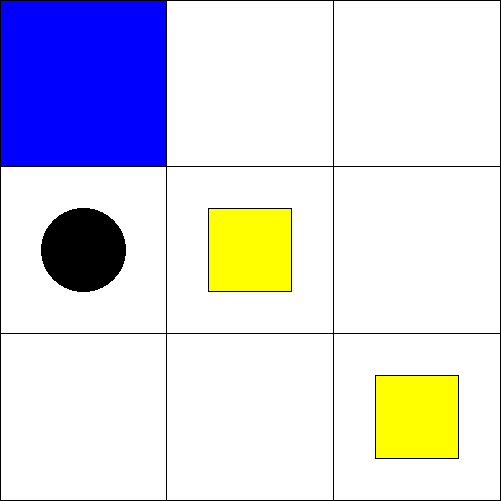

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (0, 0)
Player's new position (0, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  7


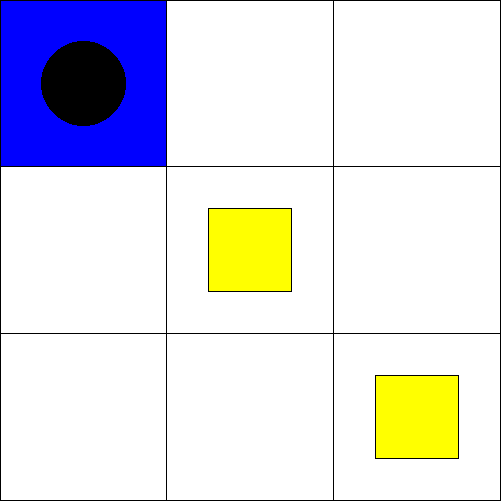

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (-1, 0)
Player's new position (0, 0)
Player's reward for this move -10000
Number of moves made to perform task:  8


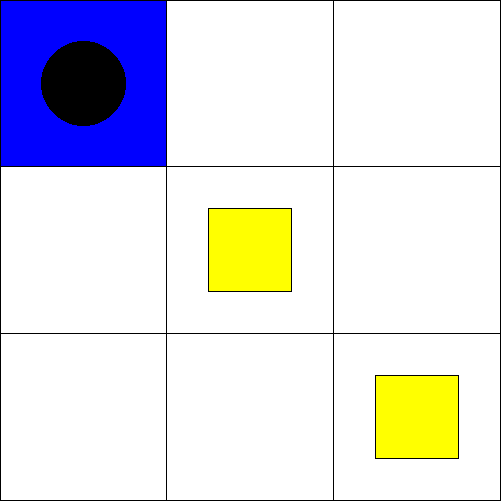

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (1, 0)
Player's new position (1, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  9


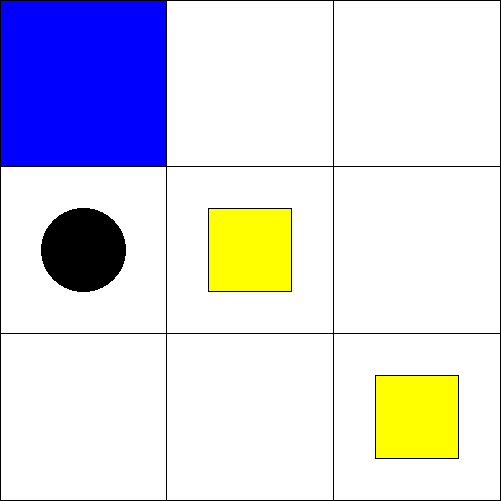

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (0, 0)
Player's new position (0, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  10


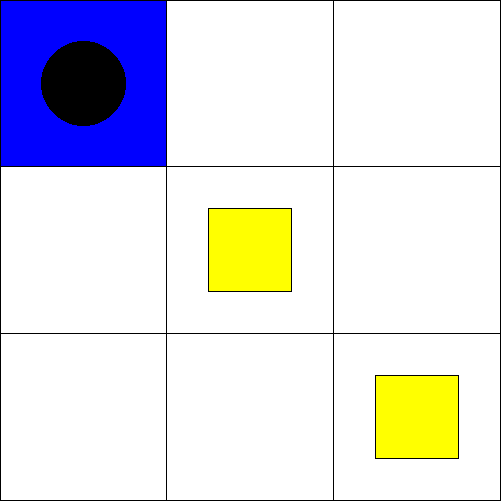

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (1, 0)
Player's new position (1, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  11


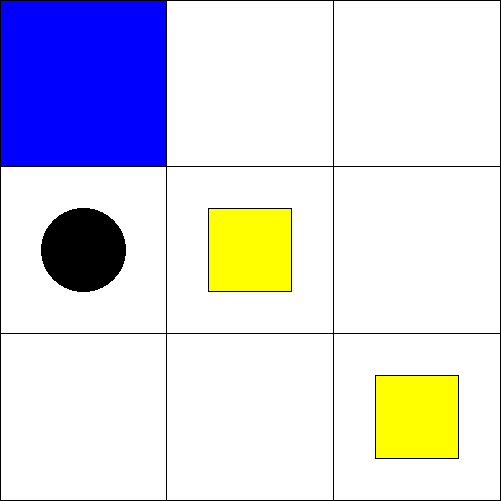

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (1, 1)
Player's new position (1, 1)
Player's reward for this move 0.0
Number of moves made to perform task:  12


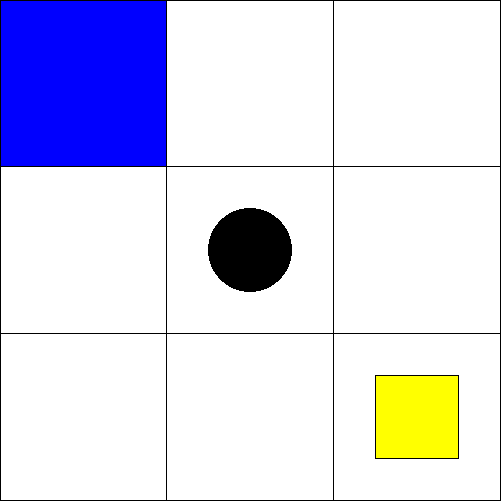

Player's position (1, 1)
Player's possible moves:  [(0, 1), (1, 0), (2, 1), (1, 2)]
Player's chosen move (1, 2)
Player's new position (1, 2)
Player's reward for this move -1.0
Number of moves made to perform task:  13


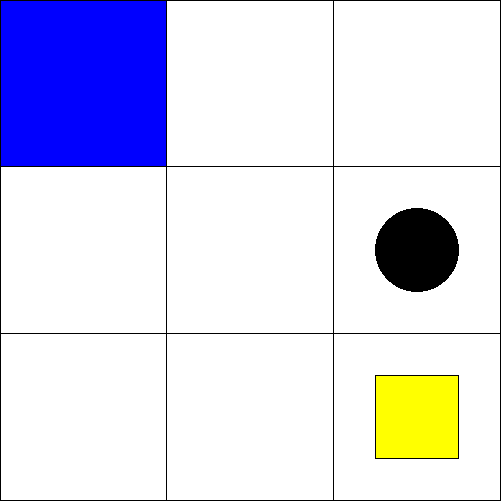

Player's position (1, 2)
Player's possible moves:  [(0, 2), (1, 1), (2, 2), (1, 3)]
Player's chosen move (0, 2)
Player's new position (0, 2)
Player's reward for this move -1.0
Number of moves made to perform task:  14


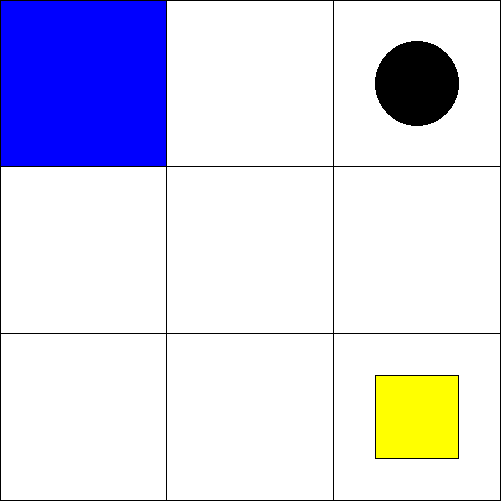

Player's position (0, 2)
Player's possible moves:  [(-1, 2), (0, 1), (1, 2), (0, 3)]
Player's chosen move (-1, 2)
Player's new position (0, 2)
Player's reward for this move -10000
Number of moves made to perform task:  15


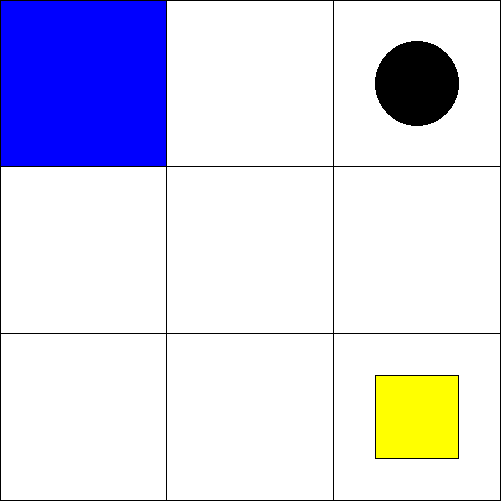

Player's position (0, 2)
Player's possible moves:  [(-1, 2), (0, 1), (1, 2), (0, 3)]
Player's chosen move (0, 1)
Player's new position (0, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  16


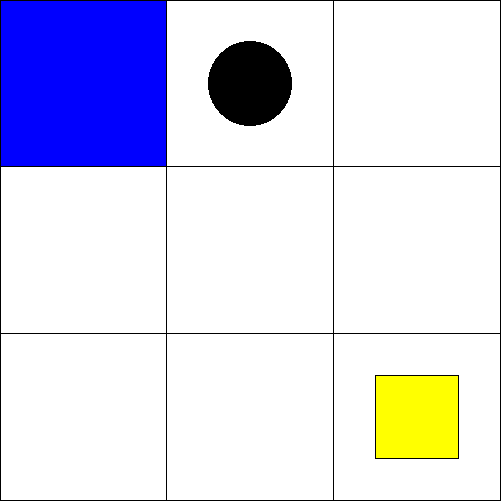

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (-1, 1)
Player's new position (0, 1)
Player's reward for this move -10000
Number of moves made to perform task:  17


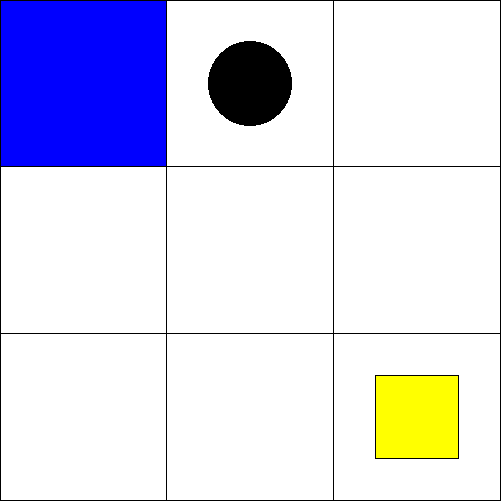

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (0, 2)
Player's new position (0, 2)
Player's reward for this move -1.0
Number of moves made to perform task:  18


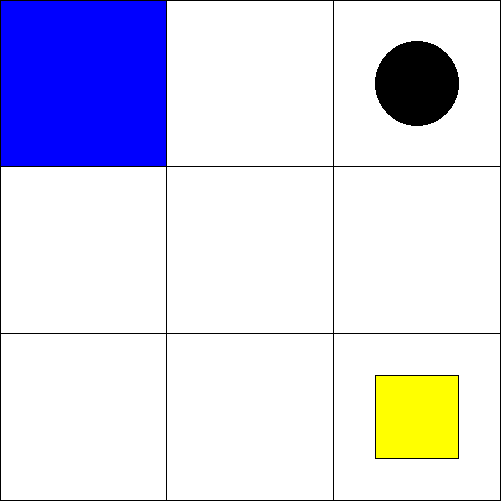

Player's position (0, 2)
Player's possible moves:  [(-1, 2), (0, 1), (1, 2), (0, 3)]
Player's chosen move (0, 3)
Player's new position (0, 2)
Player's reward for this move -10000
Number of moves made to perform task:  19


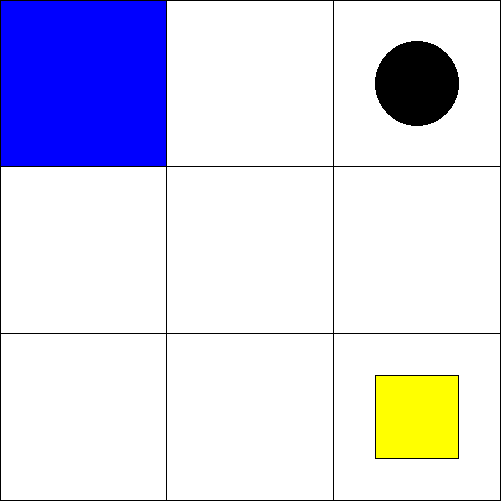

Player's position (0, 2)
Player's possible moves:  [(-1, 2), (0, 1), (1, 2), (0, 3)]
Player's chosen move (1, 2)
Player's new position (1, 2)
Player's reward for this move -1.0
Number of moves made to perform task:  20


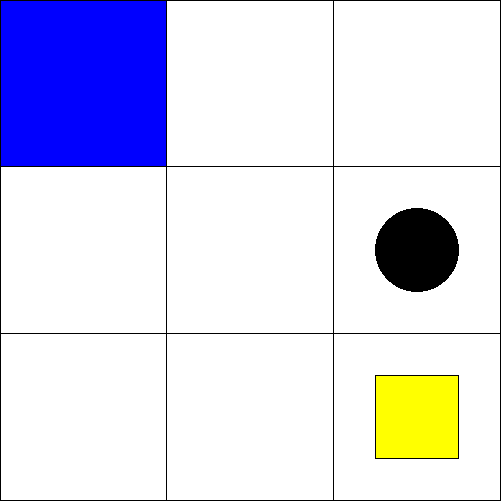

Player's position (1, 2)
Player's possible moves:  [(0, 2), (1, 1), (2, 2), (1, 3)]
Player's chosen move (1, 3)
Player's new position (1, 2)
Player's reward for this move -10000
Number of moves made to perform task:  21


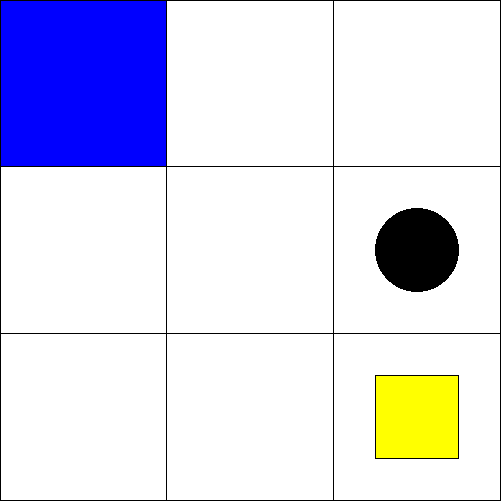

Player's position (1, 2)
Player's possible moves:  [(0, 2), (1, 1), (2, 2), (1, 3)]
Player's chosen move (0, 2)
Player's new position (0, 2)
Player's reward for this move -1.0
Number of moves made to perform task:  22


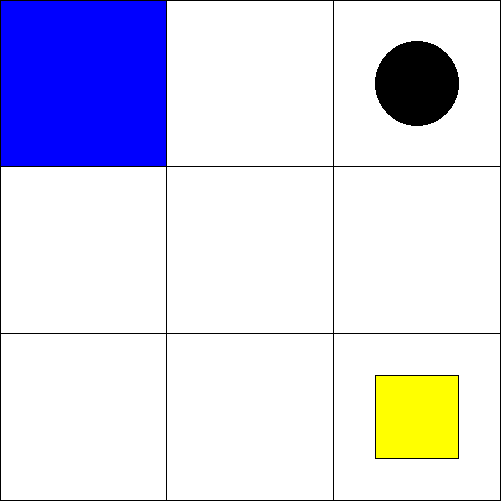

Player's position (0, 2)
Player's possible moves:  [(-1, 2), (0, 1), (1, 2), (0, 3)]
Player's chosen move (-1, 2)
Player's new position (0, 2)
Player's reward for this move -10000
Number of moves made to perform task:  23


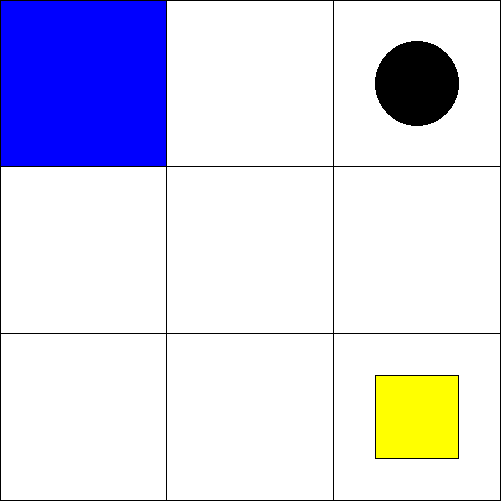

Player's position (0, 2)
Player's possible moves:  [(-1, 2), (0, 1), (1, 2), (0, 3)]
Player's chosen move (0, 3)
Player's new position (0, 2)
Player's reward for this move -10000
Number of moves made to perform task:  24


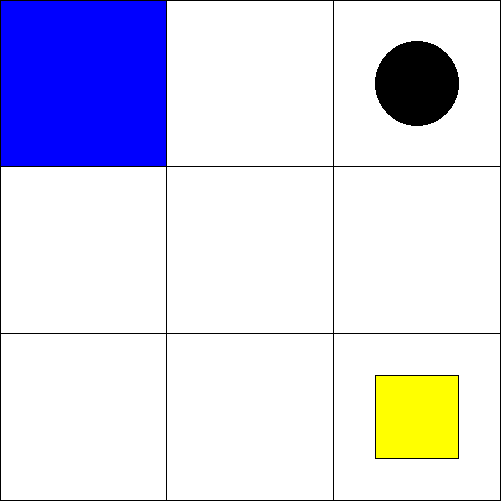

Player's position (0, 2)
Player's possible moves:  [(-1, 2), (0, 1), (1, 2), (0, 3)]
Player's chosen move (0, 1)
Player's new position (0, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  25


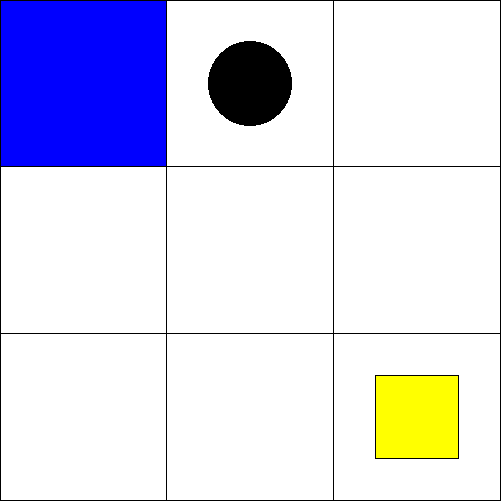

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (0, 2)
Player's new position (0, 2)
Player's reward for this move -1.0
Number of moves made to perform task:  26


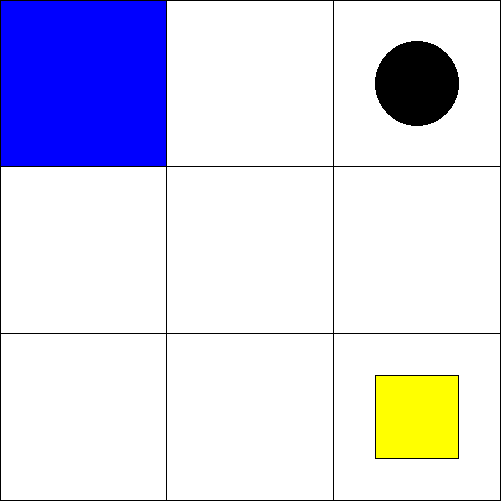

Player's position (0, 2)
Player's possible moves:  [(-1, 2), (0, 1), (1, 2), (0, 3)]
Player's chosen move (1, 2)
Player's new position (1, 2)
Player's reward for this move -1.0
Number of moves made to perform task:  27


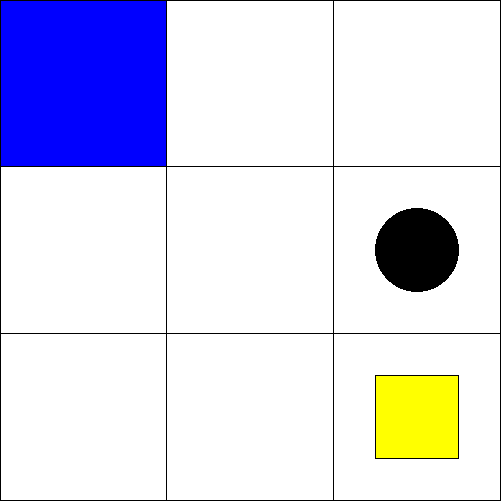

Player's position (1, 2)
Player's possible moves:  [(0, 2), (1, 1), (2, 2), (1, 3)]
Player's chosen move (0, 2)
Player's new position (0, 2)
Player's reward for this move -1.0
Number of moves made to perform task:  28


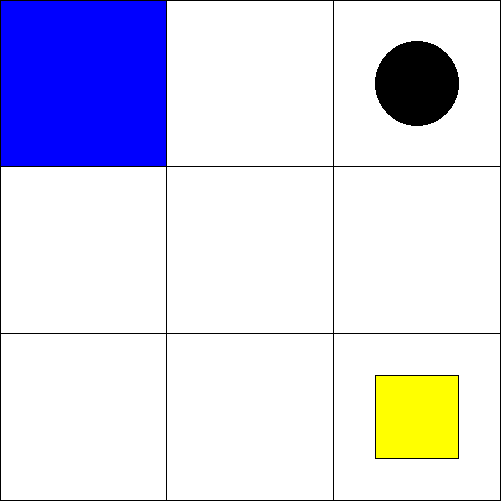

Player's position (0, 2)
Player's possible moves:  [(-1, 2), (0, 1), (1, 2), (0, 3)]
Player's chosen move (1, 2)
Player's new position (1, 2)
Player's reward for this move -1.0
Number of moves made to perform task:  29


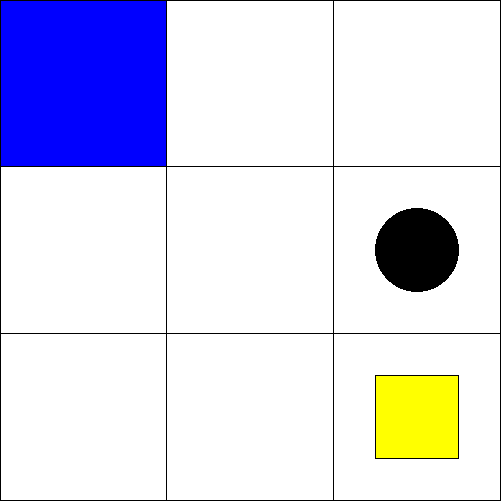

Player's position (1, 2)
Player's possible moves:  [(0, 2), (1, 1), (2, 2), (1, 3)]
Player's chosen move (1, 3)
Player's new position (1, 2)
Player's reward for this move -10000
Number of moves made to perform task:  30


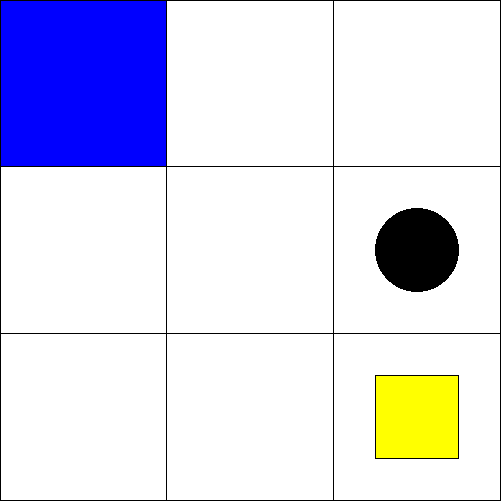

Player's position (1, 2)
Player's possible moves:  [(0, 2), (1, 1), (2, 2), (1, 3)]
Player's chosen move (0, 2)
Player's new position (0, 2)
Player's reward for this move -1.0
Number of moves made to perform task:  31


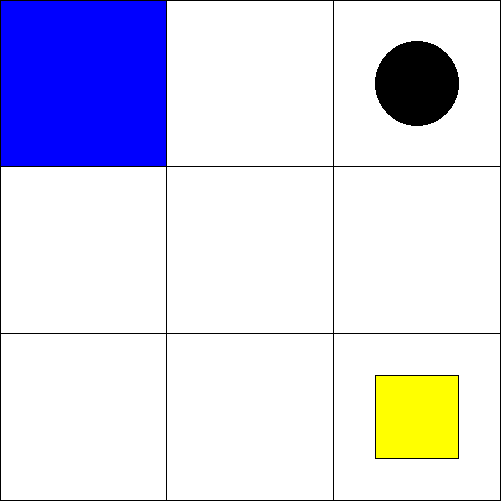

Player's position (0, 2)
Player's possible moves:  [(-1, 2), (0, 1), (1, 2), (0, 3)]
Player's chosen move (1, 2)
Player's new position (1, 2)
Player's reward for this move -1.0
Number of moves made to perform task:  32


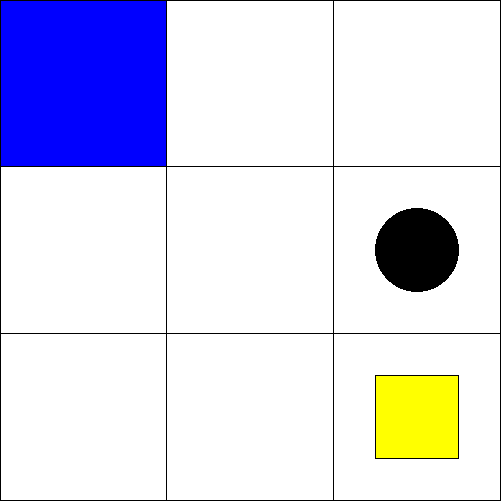

Player's position (1, 2)
Player's possible moves:  [(0, 2), (1, 1), (2, 2), (1, 3)]
Player's chosen move (1, 1)
Player's new position (1, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  33


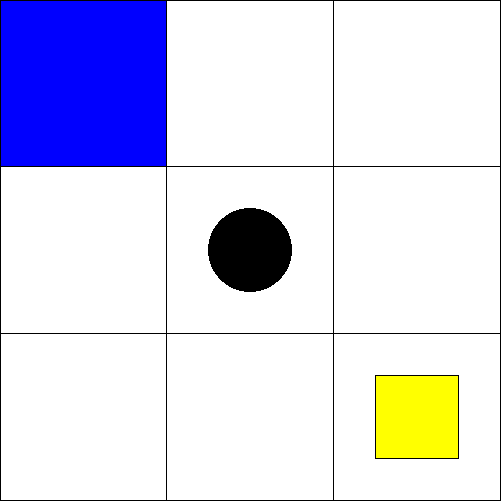

Player's position (1, 1)
Player's possible moves:  [(0, 1), (1, 0), (2, 1), (1, 2)]
Player's chosen move (1, 0)
Player's new position (1, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  34


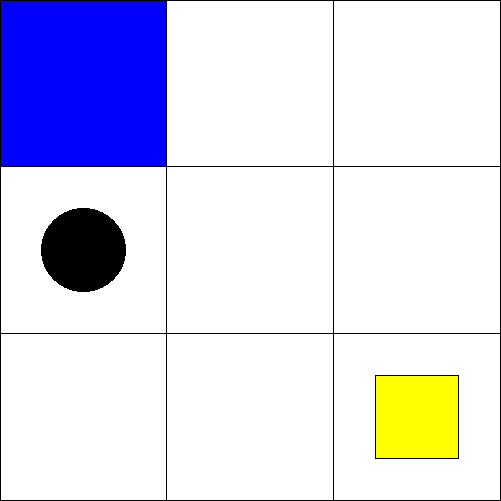

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (1, -1)
Player's new position (1, 0)
Player's reward for this move -10000
Number of moves made to perform task:  35


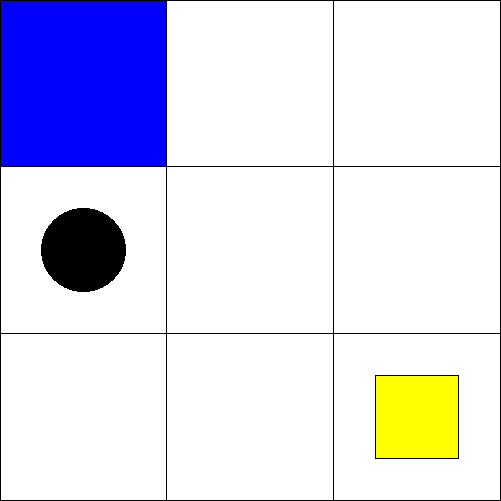

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (2, 0)
Player's new position (2, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  36


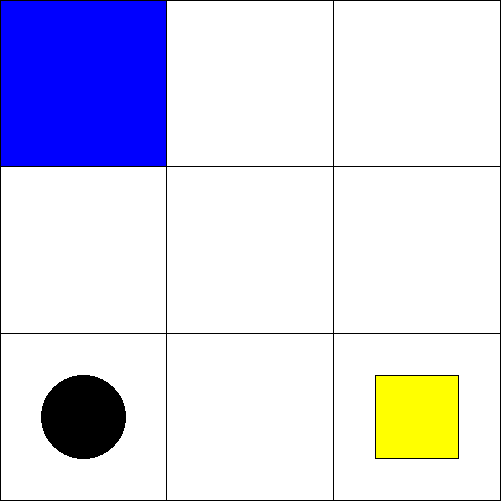

Player's position (2, 0)
Player's possible moves:  [(1, 0), (2, -1), (3, 0), (2, 1)]
Player's chosen move (2, -1)
Player's new position (2, 0)
Player's reward for this move -10000
Number of moves made to perform task:  37


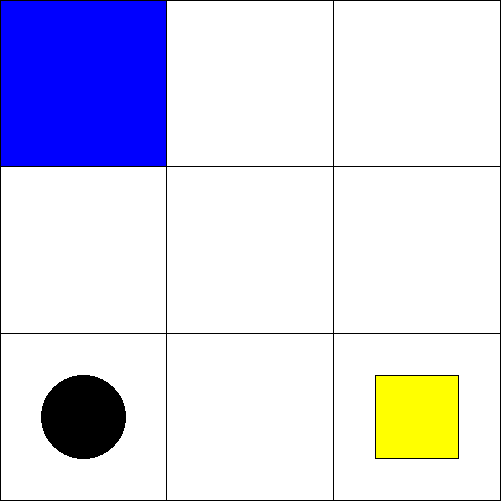

Player's position (2, 0)
Player's possible moves:  [(1, 0), (2, -1), (3, 0), (2, 1)]
Player's chosen move (1, 0)
Player's new position (1, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  38


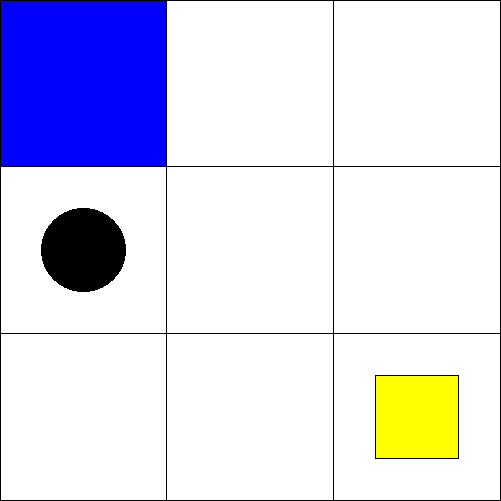

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (1, 1)
Player's new position (1, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  39


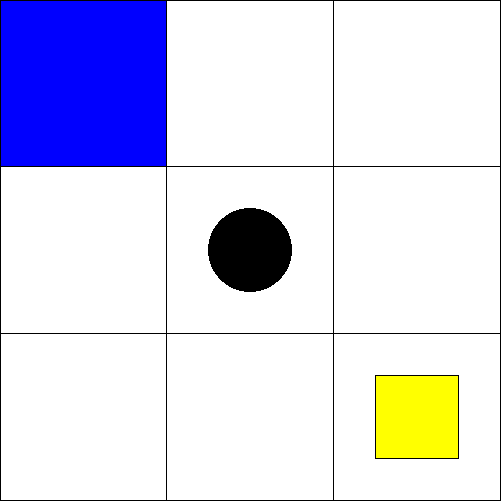

Player's position (1, 1)
Player's possible moves:  [(0, 1), (1, 0), (2, 1), (1, 2)]
Player's chosen move (0, 1)
Player's new position (0, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  40


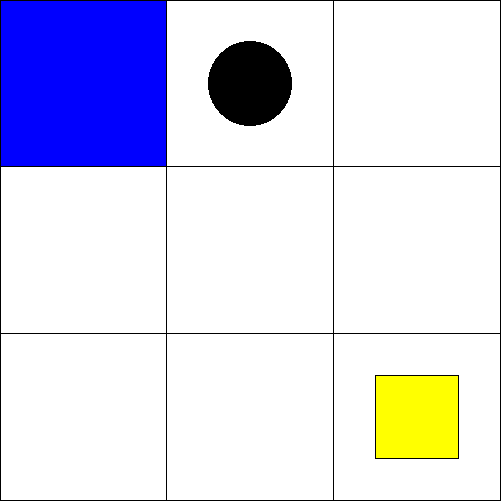

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (0, 0)
Player's new position (0, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  41


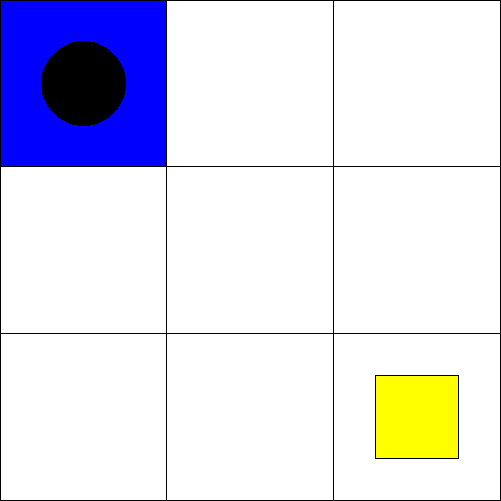

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (0, -1)
Player's new position (0, 0)
Player's reward for this move -10000
Number of moves made to perform task:  42


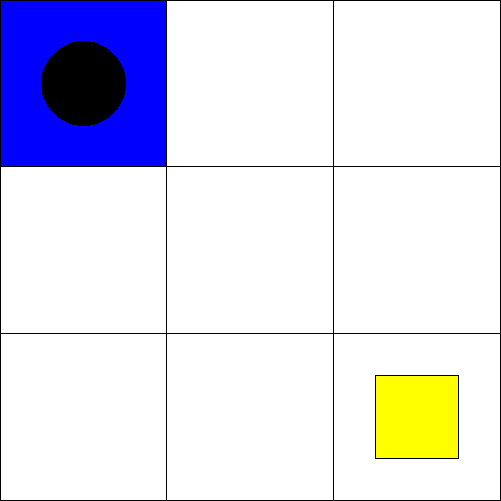

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (-1, 0)
Player's new position (0, 0)
Player's reward for this move -10000
Number of moves made to perform task:  43


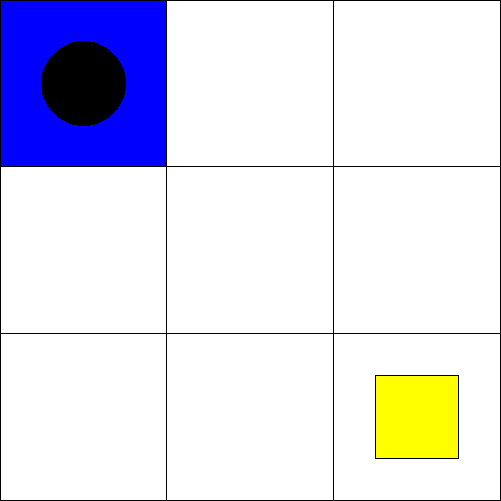

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (0, 1)
Player's new position (0, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  44


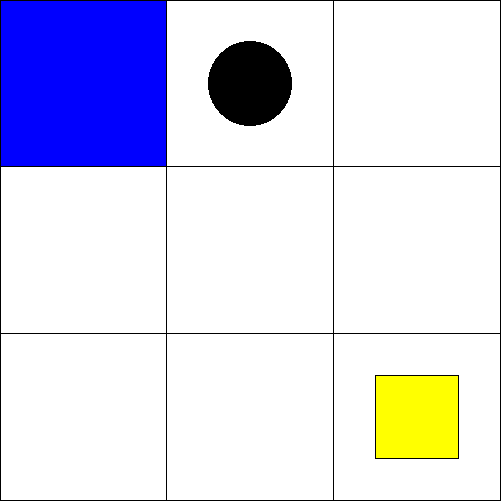

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (0, 0)
Player's new position (0, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  45


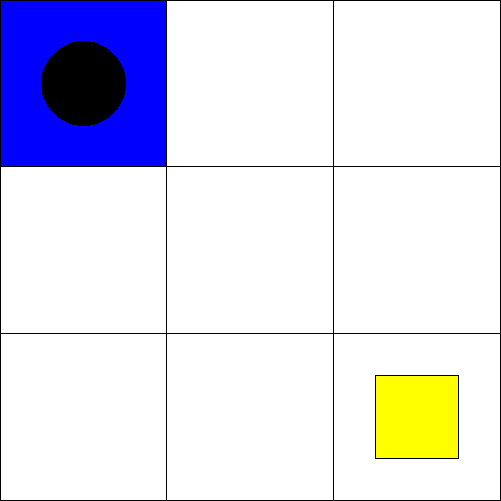

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (0, 1)
Player's new position (0, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  46


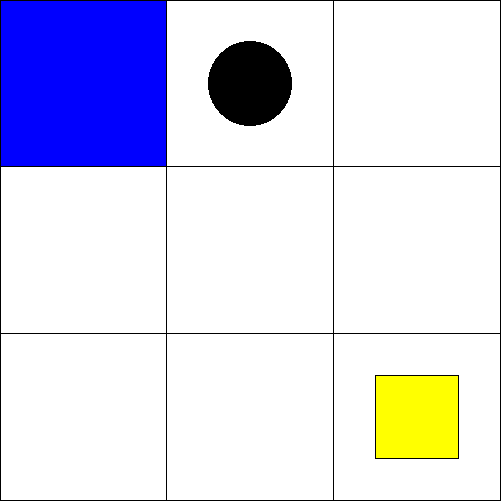

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (0, 0)
Player's new position (0, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  47


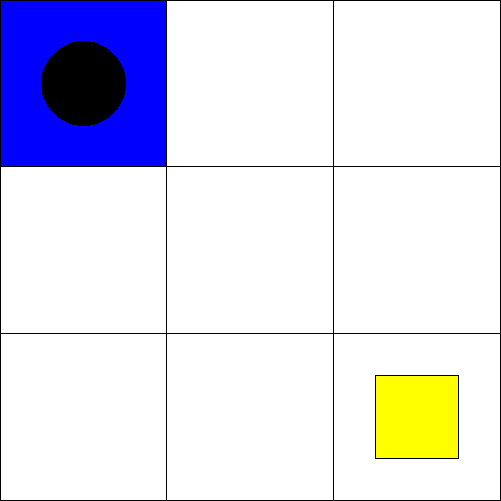

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (0, 1)
Player's new position (0, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  48


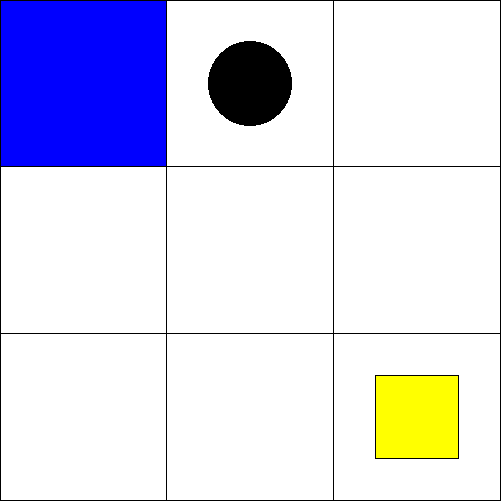

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (0, 2)
Player's new position (0, 2)
Player's reward for this move -1.0
Number of moves made to perform task:  49


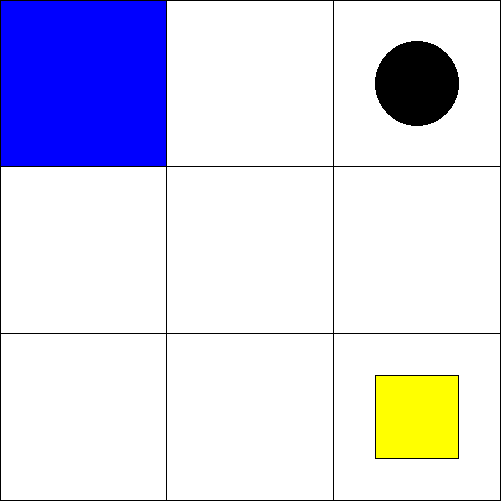

Player's position (0, 2)
Player's possible moves:  [(-1, 2), (0, 1), (1, 2), (0, 3)]
Player's chosen move (0, 1)
Player's new position (0, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  50


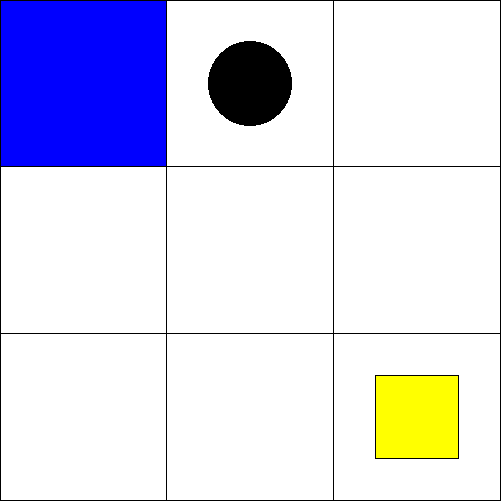

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (1, 1)
Player's new position (1, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  51


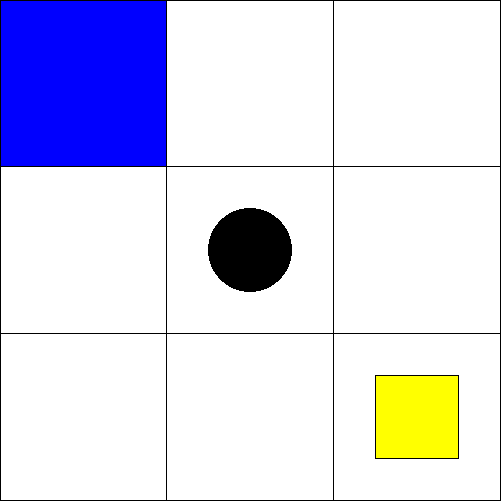

Player's position (1, 1)
Player's possible moves:  [(0, 1), (1, 0), (2, 1), (1, 2)]
Player's chosen move (1, 2)
Player's new position (1, 2)
Player's reward for this move -1.0
Number of moves made to perform task:  52


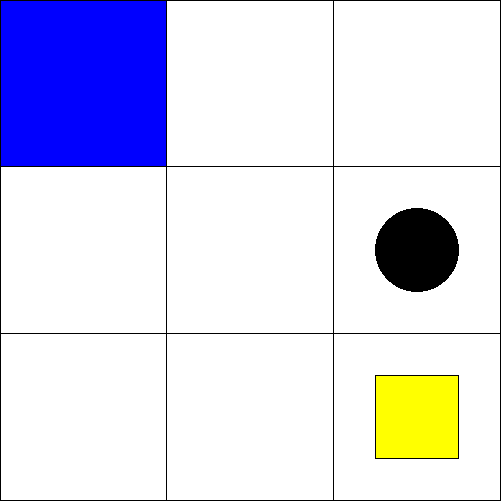

Player's position (1, 2)
Player's possible moves:  [(0, 2), (1, 1), (2, 2), (1, 3)]
Player's chosen move (0, 2)
Player's new position (0, 2)
Player's reward for this move -1.0
Number of moves made to perform task:  53


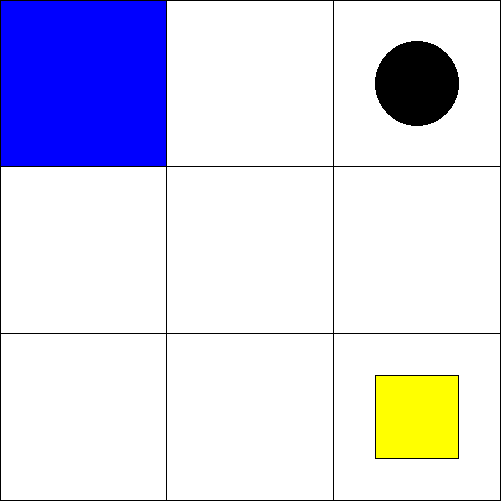

Player's position (0, 2)
Player's possible moves:  [(-1, 2), (0, 1), (1, 2), (0, 3)]
Player's chosen move (1, 2)
Player's new position (1, 2)
Player's reward for this move -1.0
Number of moves made to perform task:  54


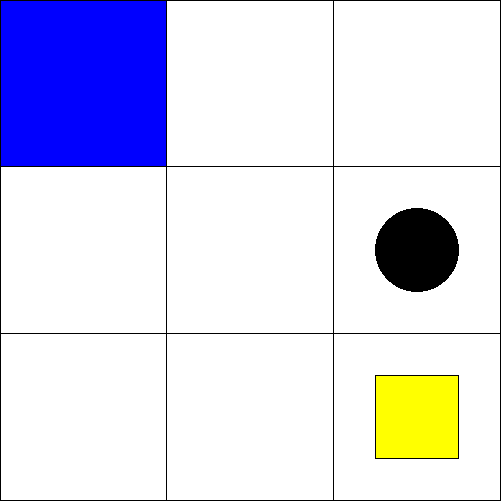

Player's position (1, 2)
Player's possible moves:  [(0, 2), (1, 1), (2, 2), (1, 3)]
Player's chosen move (0, 2)
Player's new position (0, 2)
Player's reward for this move -1.0
Number of moves made to perform task:  55


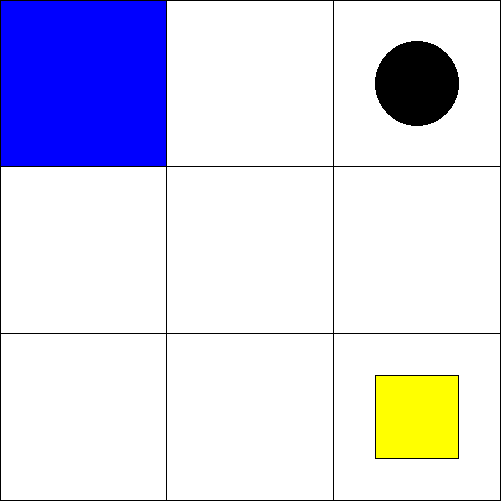

Player's position (0, 2)
Player's possible moves:  [(-1, 2), (0, 1), (1, 2), (0, 3)]
Player's chosen move (1, 2)
Player's new position (1, 2)
Player's reward for this move -1.0
Number of moves made to perform task:  56


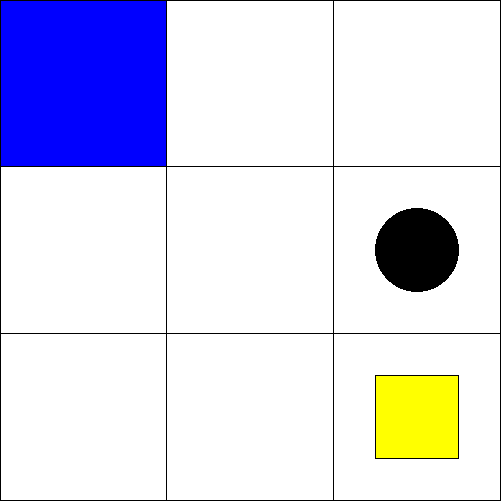

Player's position (1, 2)
Player's possible moves:  [(0, 2), (1, 1), (2, 2), (1, 3)]
Player's chosen move (1, 1)
Player's new position (1, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  57


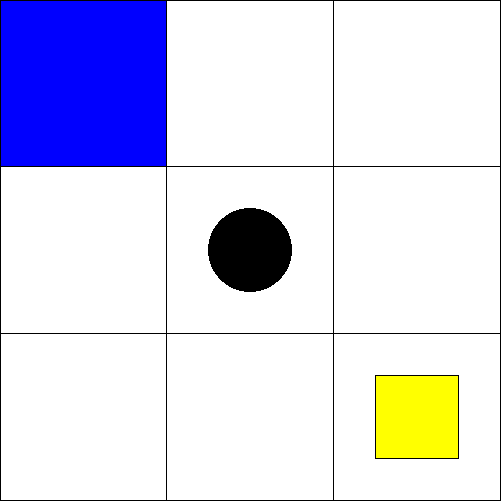

Player's position (1, 1)
Player's possible moves:  [(0, 1), (1, 0), (2, 1), (1, 2)]
Player's chosen move (1, 0)
Player's new position (1, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  58


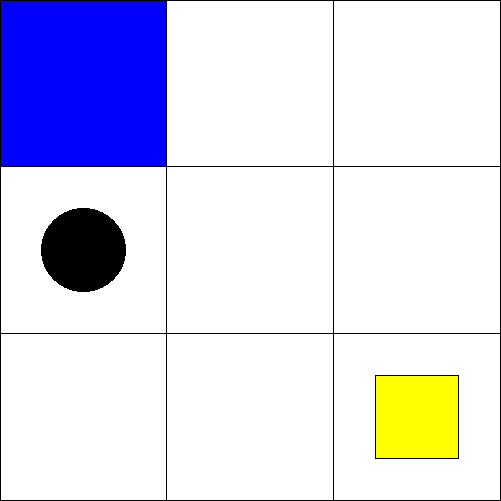

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (1, 1)
Player's new position (1, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  59


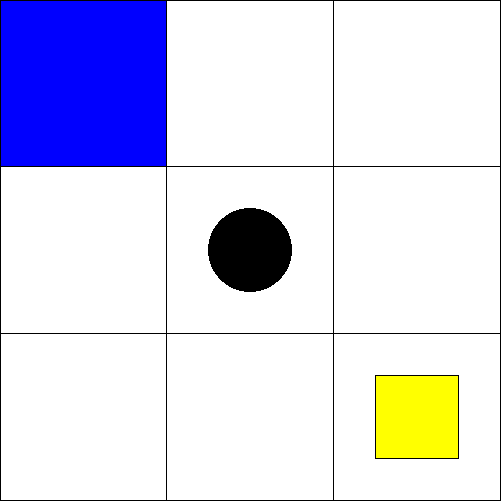

Player's position (1, 1)
Player's possible moves:  [(0, 1), (1, 0), (2, 1), (1, 2)]
Player's chosen move (0, 1)
Player's new position (0, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  60


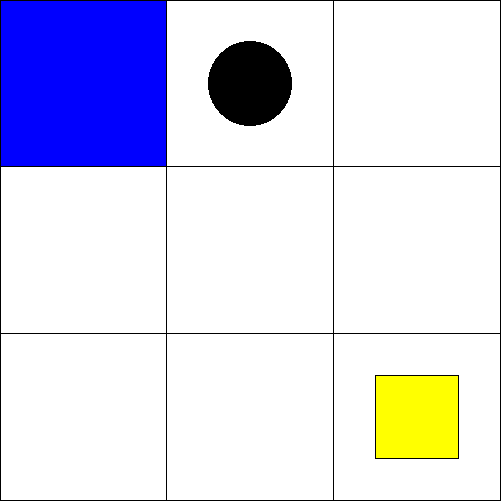

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (-1, 1)
Player's new position (0, 1)
Player's reward for this move -10000
Number of moves made to perform task:  61


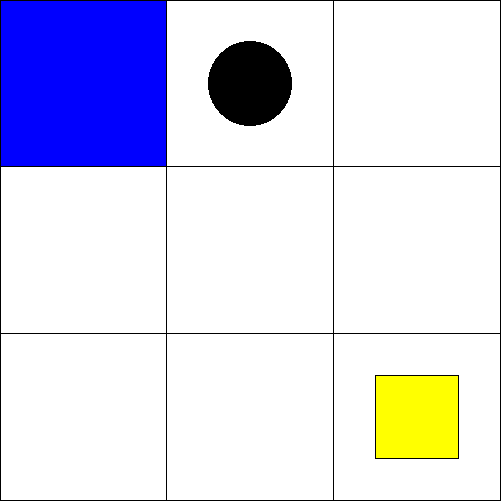

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (1, 1)
Player's new position (1, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  62


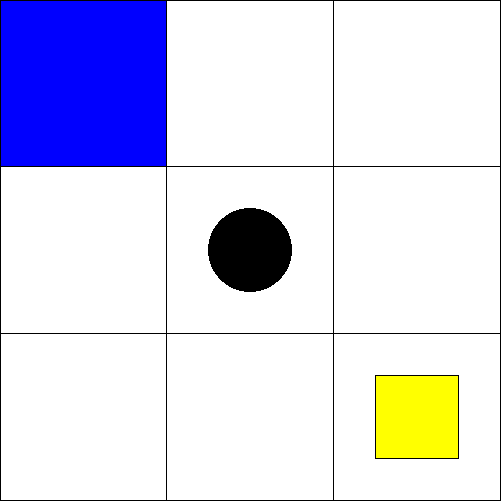

Player's position (1, 1)
Player's possible moves:  [(0, 1), (1, 0), (2, 1), (1, 2)]
Player's chosen move (1, 2)
Player's new position (1, 2)
Player's reward for this move -1.0
Number of moves made to perform task:  63


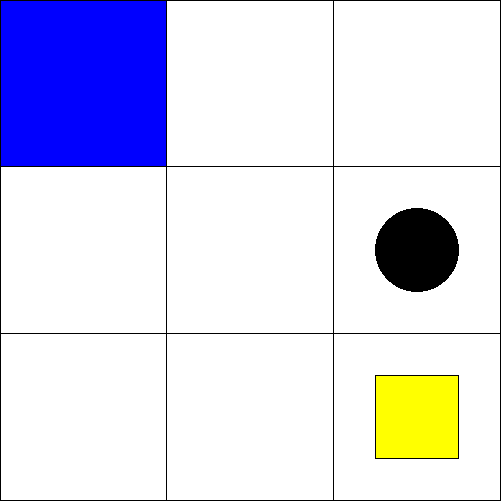

Player's position (1, 2)
Player's possible moves:  [(0, 2), (1, 1), (2, 2), (1, 3)]
Player's chosen move (1, 1)
Player's new position (1, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  64


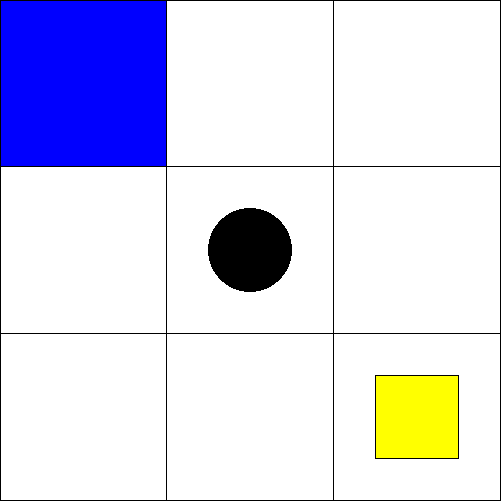

Player's position (1, 1)
Player's possible moves:  [(0, 1), (1, 0), (2, 1), (1, 2)]
Player's chosen move (0, 1)
Player's new position (0, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  65


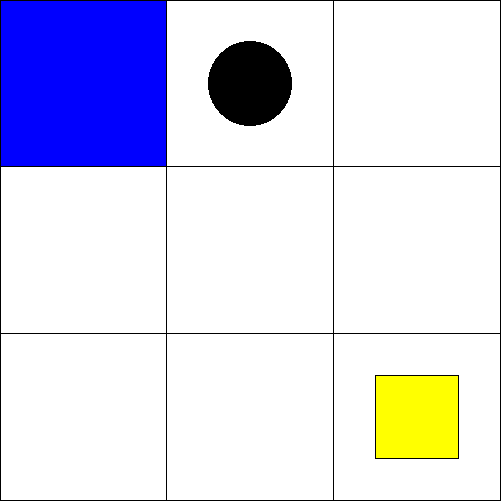

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (1, 1)
Player's new position (1, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  66


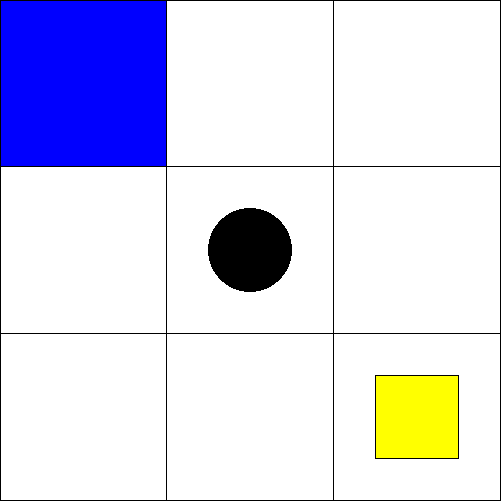

Player's position (1, 1)
Player's possible moves:  [(0, 1), (1, 0), (2, 1), (1, 2)]
Player's chosen move (2, 1)
Player's new position (2, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  67


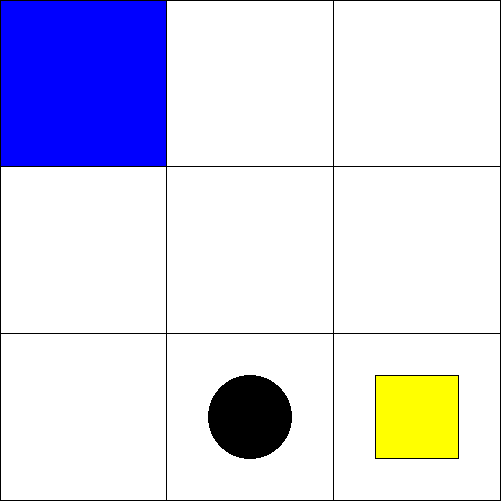

Player's position (2, 1)
Player's possible moves:  [(1, 1), (2, 0), (3, 1), (2, 2)]
Player's chosen move (1, 1)
Player's new position (1, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  68


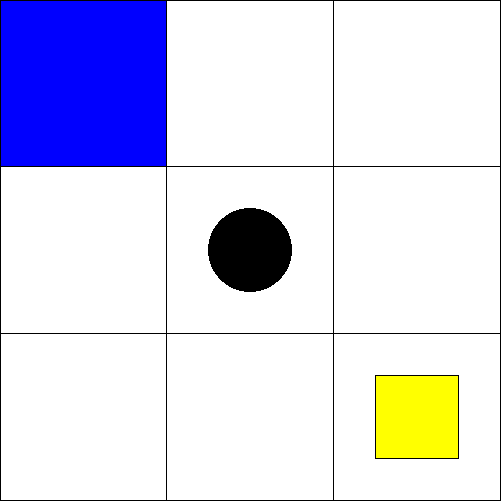

Player's position (1, 1)
Player's possible moves:  [(0, 1), (1, 0), (2, 1), (1, 2)]
Player's chosen move (0, 1)
Player's new position (0, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  69


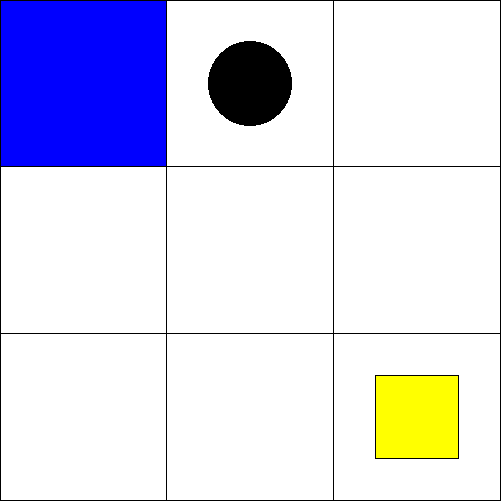

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (1, 1)
Player's new position (1, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  70


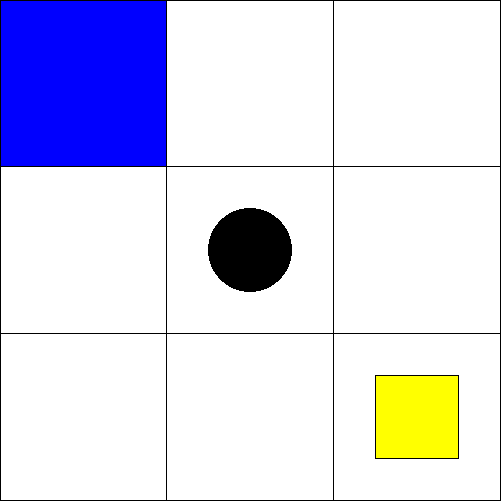

Player's position (1, 1)
Player's possible moves:  [(0, 1), (1, 0), (2, 1), (1, 2)]
Player's chosen move (1, 0)
Player's new position (1, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  71


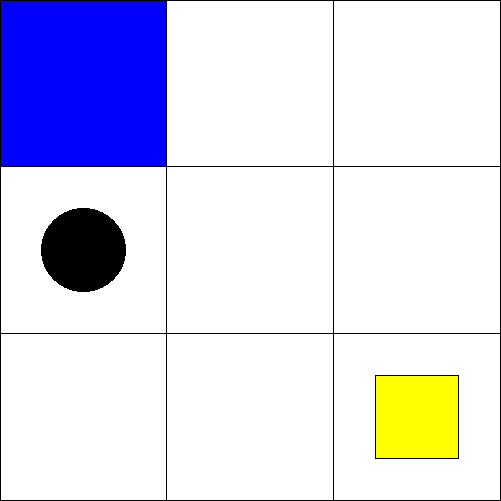

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (1, -1)
Player's new position (1, 0)
Player's reward for this move -10000
Number of moves made to perform task:  72


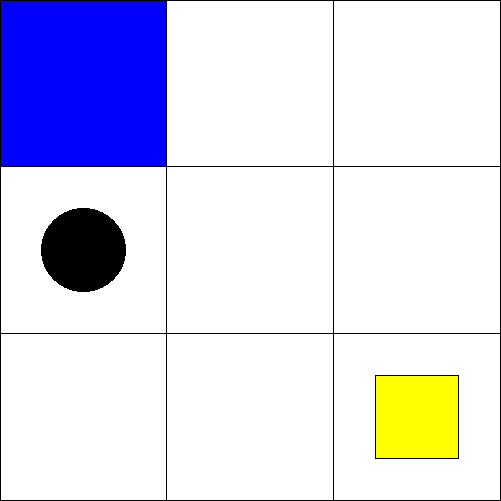

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (1, -1)
Player's new position (1, 0)
Player's reward for this move -10000
Number of moves made to perform task:  73


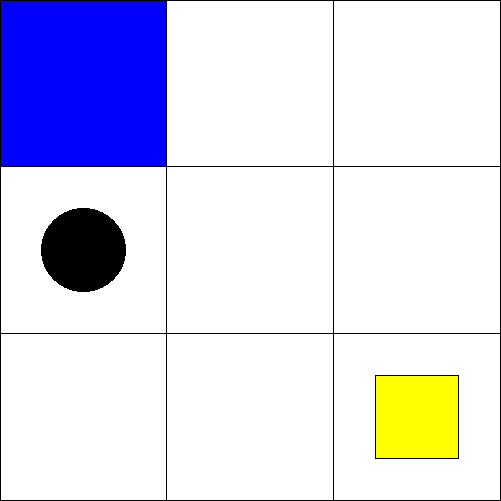

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (1, 1)
Player's new position (1, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  74


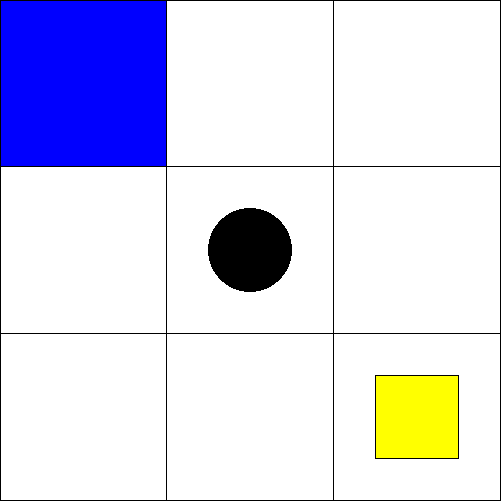

Player's position (1, 1)
Player's possible moves:  [(0, 1), (1, 0), (2, 1), (1, 2)]
Player's chosen move (1, 2)
Player's new position (1, 2)
Player's reward for this move -1.0
Number of moves made to perform task:  75


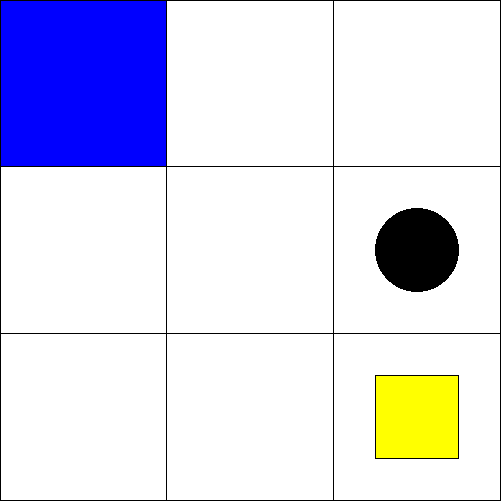

Player's position (1, 2)
Player's possible moves:  [(0, 2), (1, 1), (2, 2), (1, 3)]
Player's chosen move (1, 1)
Player's new position (1, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  76


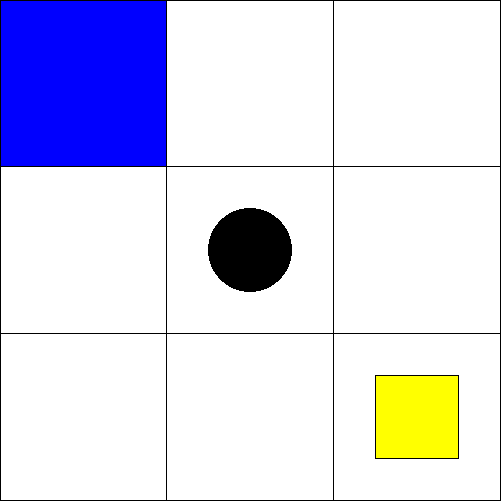

Player's position (1, 1)
Player's possible moves:  [(0, 1), (1, 0), (2, 1), (1, 2)]
Player's chosen move (1, 0)
Player's new position (1, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  77


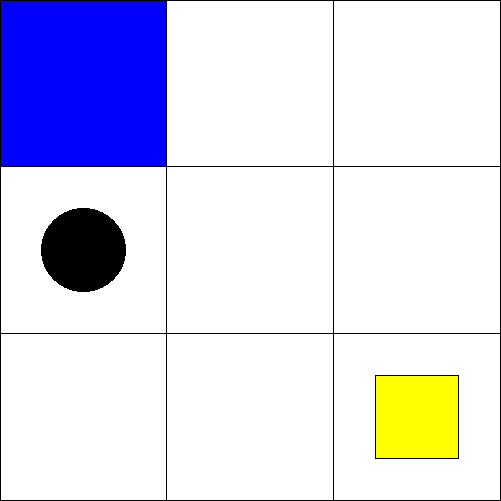

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (0, 0)
Player's new position (0, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  78


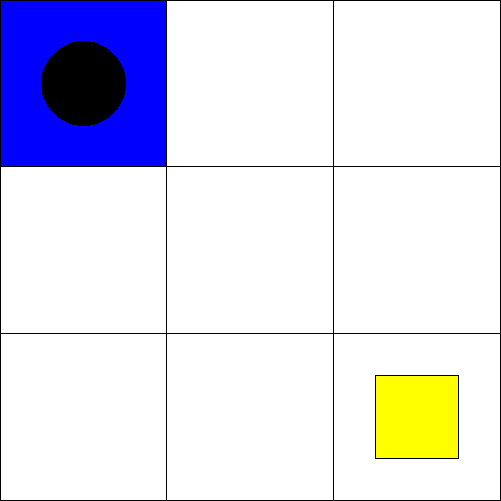

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (0, -1)
Player's new position (0, 0)
Player's reward for this move -10000
Number of moves made to perform task:  79


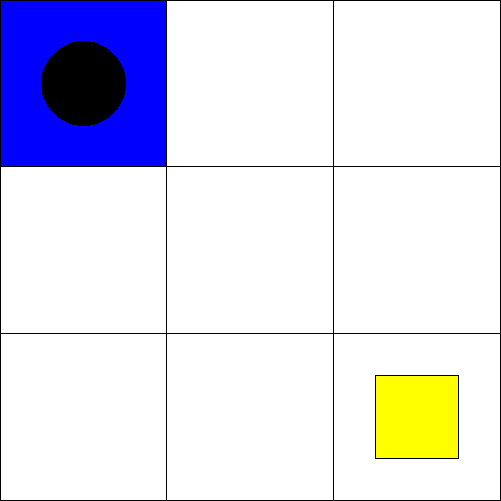

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (1, 0)
Player's new position (1, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  80


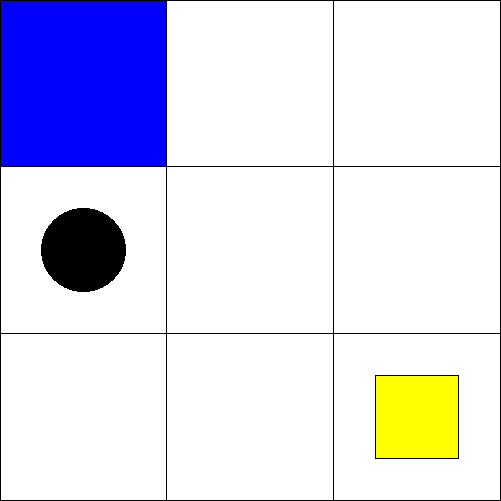

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (1, 1)
Player's new position (1, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  81


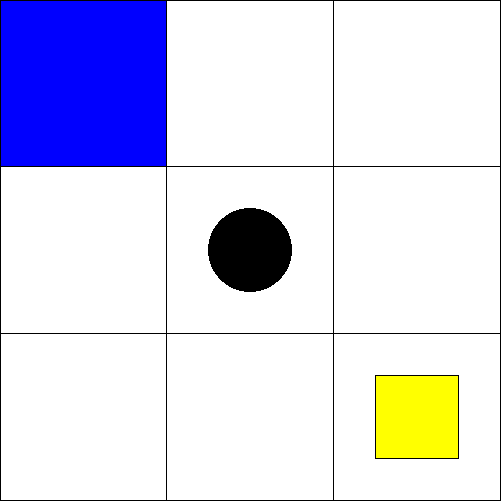

Player's position (1, 1)
Player's possible moves:  [(0, 1), (1, 0), (2, 1), (1, 2)]
Player's chosen move (2, 1)
Player's new position (2, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  82


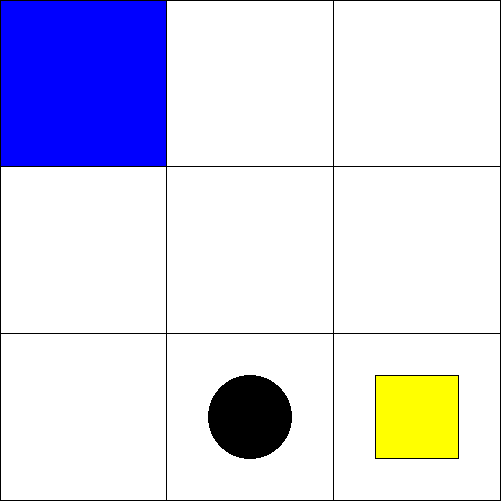

Player's position (2, 1)
Player's possible moves:  [(1, 1), (2, 0), (3, 1), (2, 2)]
Player's chosen move (1, 1)
Player's new position (1, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  83


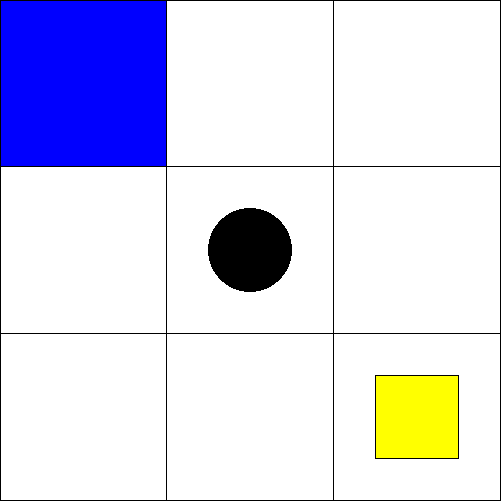

Player's position (1, 1)
Player's possible moves:  [(0, 1), (1, 0), (2, 1), (1, 2)]
Player's chosen move (2, 1)
Player's new position (2, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  84


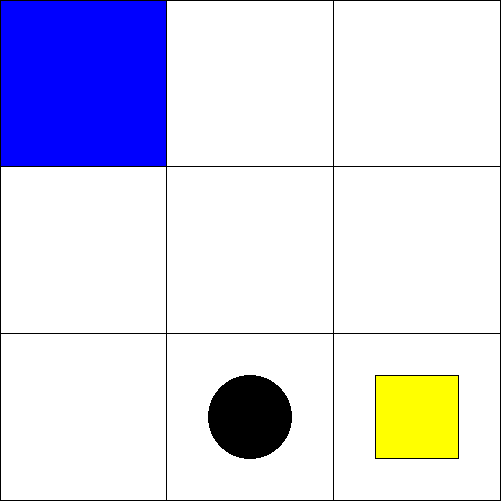

Player's position (2, 1)
Player's possible moves:  [(1, 1), (2, 0), (3, 1), (2, 2)]
Player's chosen move (2, 2)
Player's new position (2, 2)
Player's reward for this move 0.0
Number of moves made to perform task:  85


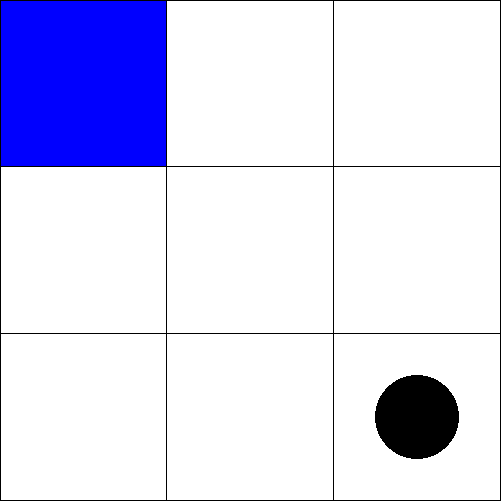

Player finished task in : 85  moves


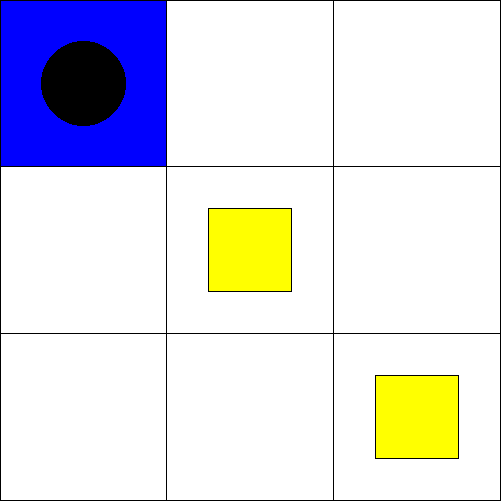

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (-1, 0)
Player's new position (0, 0)
Player's reward for this move -10000
Number of moves made to perform task:  1


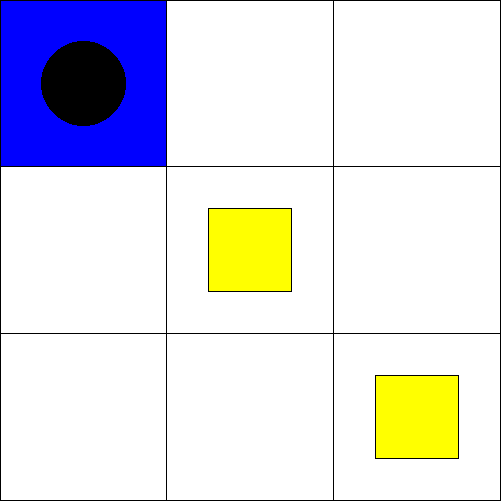

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (0, 1)
Player's new position (0, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  2


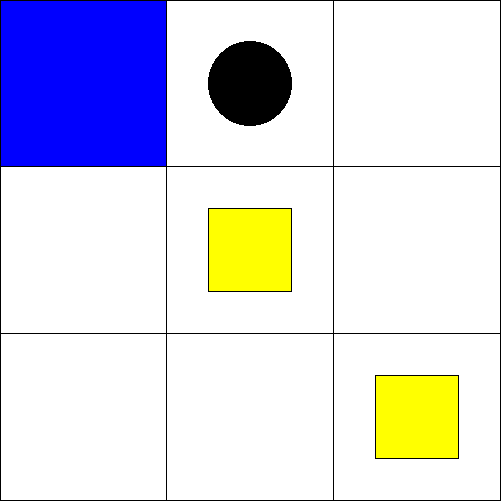

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (-1, 1)
Player's new position (0, 1)
Player's reward for this move -10000
Number of moves made to perform task:  3


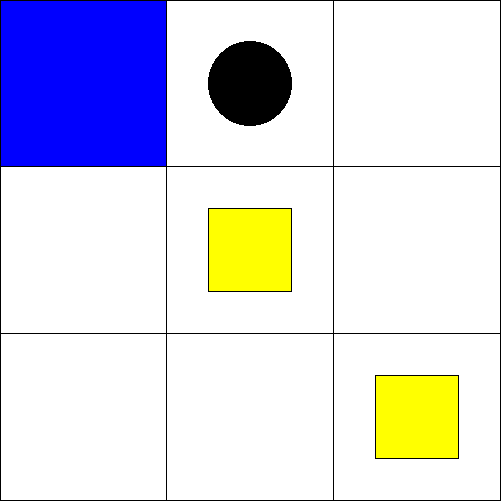

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (1, 1)
Player's new position (1, 1)
Player's reward for this move 0.0
Number of moves made to perform task:  4


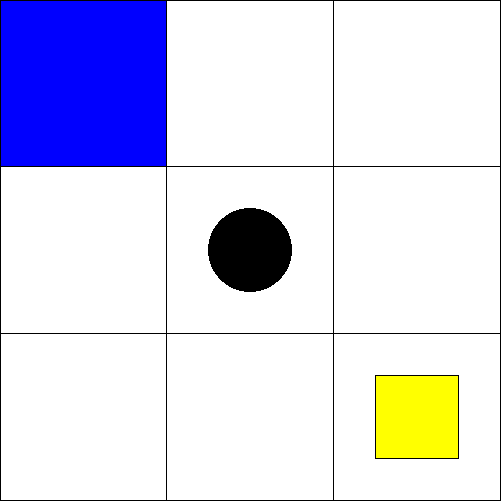

Player's position (1, 1)
Player's possible moves:  [(0, 1), (1, 0), (2, 1), (1, 2)]
Player's chosen move (2, 1)
Player's new position (2, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  5


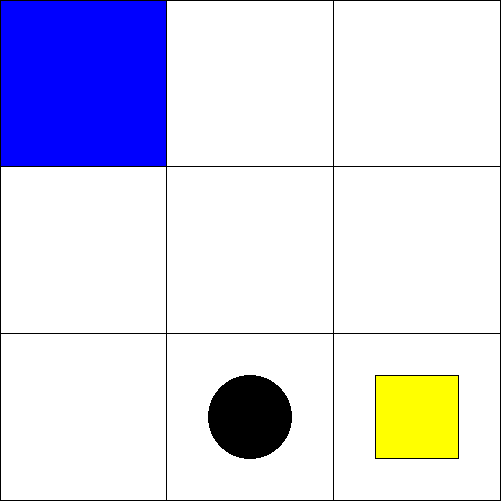

Player's position (2, 1)
Player's possible moves:  [(1, 1), (2, 0), (3, 1), (2, 2)]
Player's chosen move (1, 1)
Player's new position (1, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  6


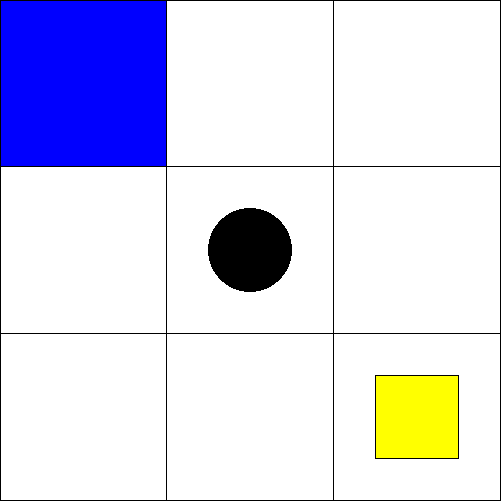

Player's position (1, 1)
Player's possible moves:  [(0, 1), (1, 0), (2, 1), (1, 2)]
Player's chosen move (2, 1)
Player's new position (2, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  7


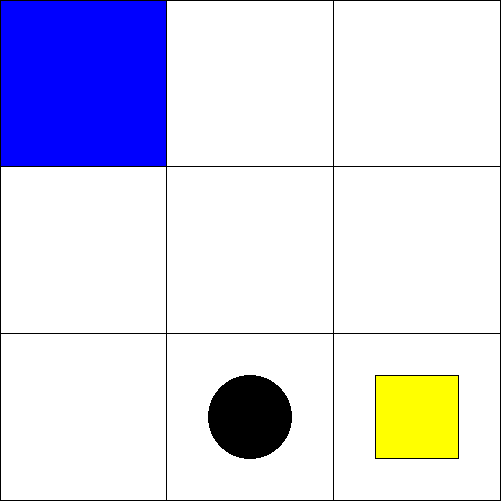

Player's position (2, 1)
Player's possible moves:  [(1, 1), (2, 0), (3, 1), (2, 2)]
Player's chosen move (2, 2)
Player's new position (2, 2)
Player's reward for this move 0.0
Number of moves made to perform task:  8


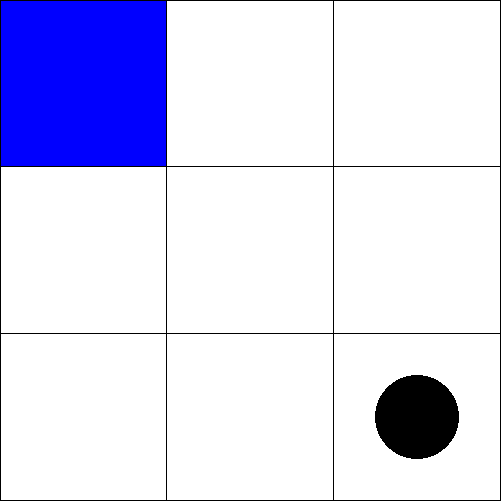

Player finished task in : 8  moves
Player scores for every episode:  [-190064.0, -20004.0]


In [11]:
reward_matrix = np.ones((3,3))*-1
reward_matrix[(1,1)] = 0
reward_matrix[(2,2)] = 0

collection_game = Collection_Game( (3,3), (0,0), [(1,1),(2,2)],reward_matrix)
play_game(collection_game, 2, output=True)

In [12]:
collection_game.print_board()

[[-1. -1. -1.]
 [-1.  0. -1.]
 [-1. -1.  0.]]


In [13]:
x = [(-1,0),(0,-1),(1,0),(0,1)]
len(x)

4